# ML Skill Exercise - Alberto Marengo

Assignment text

In our surveys, we ask a combination of both open-ended and closed-ended questions. In this exercise, you will be analyzing open text responses from a survey question which asked the following:
● Why are you cancelling?
Our team has already analyzed these responses to construct themes that will be useful for our clients to understand in terms of quality (what they are) and quantity (how many of each there are). As is the case with all of our projects, the ultimate goal is to use insights derived from this data to help companies make informed decisions.

You should have been given a file named coded_responses.csv
● Respondent IDs are the unique ids attached to a respondent.
● The text of their response is in the ‘response’ column
● ‘Theme’ column represents the themes we coded the data for.
Note: There can be responses which have multiple themes, those responses will have multiple rows in this file.

## Part 1

Let's start importing the packages and defining some functions we'll need for the analysis:

- `pre_process`: general text cleanup preprocessing function
- `_wordclouds`: generates wordcloud plot of input text

In [1]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
import pyLDAvis
import warnings
from tqdm import tqdm
from biterm.btm import oBTM
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from biterm.utility import vec_to_biterms, topic_summuary # helper functions

C:\Users\maren\Anaconda3\envs\topic_modeling\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
def pre_process(text):
    text = text.encode("ascii", "ignore");
    text = text.decode()
    text = text.lower()
    text = re.sub(pattern=r"\S*@\S*\s?", repl="", string=text)  # Emails
    text = re.sub(pattern=r"[0-9]", repl="", string=text)  # remove numbers
    text = re.sub(pattern=r"\n|\r", repl=" ", string=text)  # remove new line
    text = re.sub(pattern=r"\n|\r", repl=" ", string=text)  # remove new line
    text = re.sub(pattern=r"-[ ]*\b", repl="", string=text)  # correct words hyphenated in wrapping
    text = re.sub(pattern=r"\s+", repl=" ", string=text)  # remove white space
    text = re.sub(pattern=r"u[+]\w+", repl="", string=text)  # non-ascii conversions like "u+fb02"
    text = re.sub(pattern=r"u[+]\w+", repl="", string=text)  # non-ascii conversions like "u+fb02"
    text = re.sub(pattern=r"([a-z\._]+)[.](jpg|png|jpeg|pdf|gif)|([a-z\._]+)(jpg|png|jpeg|pdf|gif)|(jpg|png|jpeg|pdf|gif)",
                  repl="", string=text)  # image file extensions
    text = re.sub(pattern=r"(https?:\/\/|www.)+\S+", repl="", string=text)  # websites
    text = re.sub(pattern=r"[^A-Za-z0-9]+", repl=" ", string=text)  # removes non-english
    return text

In [3]:
def _wordclouds(inputs, max_words=5000):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    long_string = ', '.join(inputs)
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=max_words, contour_width=3,
                          contour_color='steelblue', width=900, height=900, collocations=False)
    # Generate a word cloud
    wordcloud.generate(long_string)
    ax.imshow(wordcloud)
    ax.axis('off')
    fig.suptitle('Word Cloud', fontsize=16)
    # fig.savefig(fname=f'output/wordcloud.png')

We start loading the data into a pandas DataFrame and create a boolean column for text that are longer than 3 words. We'll only keep these rows for the preliminary analysis.

In [4]:
df = pd.read_csv('data/coded_responses.csv')

In [5]:
df['keep'] = df['response'].apply(lambda text: True if len(text.split())>3 else False)
df

,question,respondent_id,response,theme,keep
0,Why are you cancelling?,1779533,seen what I like already,NaN,True
1,Why are you cancelling?,1779397,"You keep canceling really good, popular series!",NaN,True
2,Why are you cancelling?,1779811,Getting through cell provider,NaN,True
3,Why are you cancelling?,1779968,Budget cuts,Reducing expenses / financial constraints,False
4,Why are you cancelling?,1779967,Cannot have multiple users,Object to sharing restrictions,True
...,...,...,...,...,...
658,Why are you cancelling?,1779372,Your pricing is terrible. You keep increasing ...,Constant price rise / increase,True
659,Why are you cancelling?,1779371,Your profits are up and you're *raising* my pr...,Constant price rise / increase,True
660,Why are you cancelling?,1779370,Your rates are higher than others who do the s...,Prefer competition,True
661,Why are you cancelling?,1779370,Your rates are higher than others who do the s...,Too expensive,True


Let's check if we have any duplicated rows in the dataset

In [6]:
df.duplicated().any()

False

In [7]:
df[df.duplicated(subset='response')==True]

,question,respondent_id,response,theme,keep
15,Why are you cancelling?,1779957,I need to change country of billing,Moving / changing locations,True
25,Why are you cancelling?,1779948,moving in with my bf. He has an subscription a...,Moving / changing locations,True
32,Why are you cancelling?,1779942,Prices keep going upward it is now too much ex...,Constant price rise / increase,True
40,Why are you cancelling?,1779935,To expensive compared to others so switching,Too expensive,True
61,Why are you cancelling?,1779915,Because I can�t share with my grandkids out of...,Object to sharing restrictions,True
...,...,...,...,...,...
640,Why are you cancelling?,1779387,You raised your price almost 50%. I also don�t...,Constant price rise / increase,True
649,Why are you cancelling?,1779379,Your company has far too many price increases....,Constant price rise / increase,True
657,Why are you cancelling?,1779372,Your pricing is terrible. You keep increasing ...,Corporate greed / taking advantage of customers,True
658,Why are you cancelling?,1779372,Your pricing is terrible. You keep increasing ...,Constant price rise / increase,True


It looks like we have some duplicated response but, because they are assigned to different users, we'll keep them all.

In [8]:
df.isna().any()

question         False
respondent_id    False
response         False
theme             True
keep             False
dtype: bool

It also looks like we have some Nan values in the 'theme' column.

### Wordcloud

Let's start by plotting the wordcloud of all the response to check what are the most frequent words.

In [9]:
texts = df[df['keep']==True]['response'].tolist()
texts = [pre_process(text) for text in texts]

In [10]:
len(texts)

501

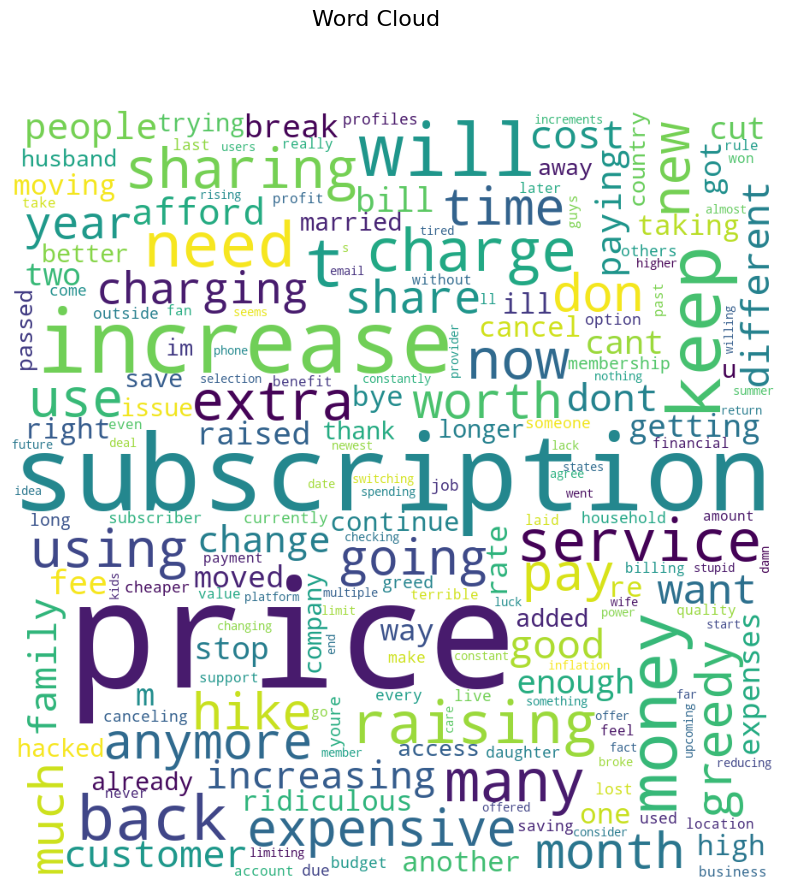

In [11]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from imp import reload
warnings.filterwarnings('ignore')
_wordclouds(texts, max_words=200)

It looks like words 'price', 'increase', 'subscription' are the most frequent.

## Biterm Topic Model (for short text)

resource: [https://pypi.org/project/biterm/](https://pypi.org/project/biterm/)

To assign topics, we will use a specific topic model called biterm (BTM) that is well suited for short text.

The conventional topic models implicitly capture the document-level word co-occurrence patterns to reveal topics, and thus suffer from the severe data sparsity in short documents. In BTM we learn the topics by directly modeling the generation of word co-occurrence patterns (i.e. biterms) in the whole corpus. The major advantages of BTM are that:
- BTM explicitly models the word co-occurrence pat- terns to enhance the topic learning; and
- BTM uses the aggregated patterns in the whole corpus for learning topics to solve the problem of sparse word co-occurrence patterns at document-level.

The parameter inference is done using Gibbs sampling, a simple and widely applicable Markov chain Monte Carlo algorithm. The basic idea of Gibbs sampling is to estimate the parameters alternatively, by replacing the value of one variable by a value drawn from the distribution of that variable conditioned on the values of the remaining variables.

In [12]:
 # vectorize texts
# vec = CountVectorizer(stop_words='english')
vec = CountVectorizer()
X = vec.fit_transform(texts).toarray()

In [13]:
# get vocabulary
vocab = vec.get_feature_names_out()

# get biterms
biterms = vec_to_biterms(X)

Let's  create a training loop to try different topic numbers and get the coherence score to choose the best one.

In [14]:
def train(biterms, start=2, end=50):
    model_list = []
    topics_list = []
    coherence_score_list = []
    for num_topics in tqdm(range(start, end)):
        btm = oBTM(num_topics=num_topics, V=vocab)
        for i in range(0, len(biterms), 100): # prozess chunk of 200 texts
            biterms_chunk = biterms[i:i + 100]
            btm.fit(biterms_chunk, iterations=50)
        topics = btm.transform(biterms)
        res = topic_summuary(btm.phi_wz.T, X, vocab, df.shape[0])
        model_list.append(btm)
        topics_list.append(topics)
        coherence_score_list.append(np.mean(res['coherence']))
    return range(start, end), model_list, topics_list, coherence_score_list

In [ ]:
n_range, models, topics, coherence = train(biterms)

100%|██████████| 50/50 [00:08<00:00,  5.72it/s]

100%|██████████| 50/50 [00:07<00:00,  7.03it/s]

100%|██████████| 50/50 [00:13<00:00,  3.75it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.92it/s]


100%|██████████| 50/50 [00:16<00:00,  2.94it/s]

100%|██████████| 50/50 [00:25<00:00,  1.97it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.39it/s]


Topic 0 | Coherence=-286474.18 | Top words= to the price and it prices you is for not too will my be keep have your raising this now are just many me back subscription expensive much of worth money other time only anymore that increasing increase so good year need pay do we after but in customer ill new use with at as was service like going why no raised months up can enough services afford want canceling long am or consider subscriber rates greedy dont increases on checking luck increments access if seems last added fact currently used cancel month continues again come greed us once has more lost there being bill make company customers biannually profit because starting entertaining additional one stop life fees what an different ll loyalty alarming feel change moved far bye by almost where cut when options don high rate card using never charged break about others without budget save offer profiles business right every cant job charges compromised country especially face forcing iny p

  2%|▏         | 1/48 [01:26<1:07:38, 86.36s/it]

Topic 1 | Coherence=-295523.35 | Top words= and you the price my subscription to extra for your with of charge that in is charging money increase greedy subscriptions share me are not when using sharing family increases it out no about have keep many don hikes pay people youre going has like prices paying different re will want because more bill also im too way was over better good if other years now just gonna need daughter reason kept few she raising outside past fan be thank cheaper bye news an anyways sign uses ut college worth company up idea states limit power we hike services on two its ridiculous taste disgusting extortion only where fee got dont this since so change from live use am cant but been terrible months getting service charges married already anticonsumer newest pricing addition locations high can won support keeps longer saving another moving greed upcoming how kids willing they deal back moved husband changing lack cancel selection issues problem without profiles co


100%|██████████| 50/50 [00:08<00:00,  5.57it/s]

100%|██████████| 50/50 [00:07<00:00,  6.96it/s]

100%|██████████| 50/50 [00:13<00:00,  3.76it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.96it/s]


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.52it/s]


Topic 0 | Coherence=-266793.69 | Top words= you extra and subscription the to my that of for charging share price not using with your increase greedy pay family about charge bill money youre subscriptions because have people hikes many was so out are it sharing want services paying other im better when just prices is like if also me cheaper raising but way kept gonna reason outside keep past fan don an few years over news idea power its limit states only do disgusting extortion taste now company no different without even after ill newest cant care more hike card good too garbage compromised continues charged guys credit customers option this in automatically wanted allowed bank told issues why climb benefit how from stay grandkids profiles dont will they what first added used before rate something recent talk she one limited agree support stop their expenses longer needed service take need again parents won account put start fair charges expected things continue been forth bye between 

  4%|▍         | 2/48 [03:01<1:10:16, 91.65s/it]

Topic 2 | Coherence=-275152.08 | Top words= price the and it is you prices for to not your too are keep me worth raising going increase no increasing charge expensive re more greedy will when much now good year up enough increases bye new this only my anymore daughter customer with at that raised thank of after time ut sign uses anyways college many have consider rates just like money can service she other long extra subscriber in but company or be options seems charges sharing high if has afford do currently again us cost there make entertaining profit starting biannually being additional terrible use alarming loyalty feel so every pricing addition last stop far way added fees what kids subscription ill profiles others fact never keeps nice choice forcing keeping iny especially face shoves business pop email deal need life greed right months reactivate makes cared rectifying means leave continuous problem issue forever understand were hiking begin wouldn give we about saving dont same


100%|██████████| 50/50 [00:08<00:00,  5.78it/s]

100%|██████████| 50/50 [00:06<00:00,  7.22it/s]

100%|██████████| 50/50 [00:12<00:00,  3.88it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.98it/s]


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]

100%|██████████| 50/50 [00:25<00:00,  1.98it/s]

100%|██████████| 50/50 [00:00<00:00, 1612.92it/s]


Topic 0 | Coherence=-255184.41 | Top words= and to it was subscription that so have price are other keep the using better services your not you raising my people kept reason gonna youre but im prices cheaper charge is just if do pay out anymore only for dont now money bill because charging an in extra ill increase charged afford bank hike compromised card has why too after told wanted allowed option credit automatically since guys up benefit climb one like cant without down me kids selection hacked or much added putting on choose more need when made from continues business make no service should between resubscribe decisions date letting making doesnt done well change span sense been activities deteriorated enough at member us inflation into with use gone share went extortion drastically needed cost taste caused yall time customers thanks will unable havent by forth years be hardly stealing drive finally goes competitive shouldn pick charges help scales tipped creep quality market mans

Topic 2 | Coherence=-271830.24 | Top words= to and the will be price my you back in need subscription money is this we have different for of increases it use where many that with just more greed too good can time other want on dont am two as why subscriptions me access don cancel checking luck increments your again months fact canceling not now pay once live upcoming got fee month cut come change moved saving almost are raised another locations anticonsumer ridiculous new only break married shady tried save bye ill charge if offer sharing email like consider taking used since paying but deal start few due at budget give forever makes reactivate problem customer kids issue never continuous rectifying country re payment trying take ll before going prices get afford service try much anymore end services first getting also one membership losing what expenses mom moving job move tight location by using last places some loose do restrict won unfair city husband intolerable when own from see 

  6%|▋         | 3/48 [04:41<1:11:38, 95.51s/it]

Topic 3 | Coherence=-267757.17 | Top words= you the extra with subscription my price of and share charging to greedy family money about subscriptions hikes that increase many your when bill using don has like me because also over for not way in paying outside keep sharing few fan past charge years out want news an power limit idea is states pay company youre no disgusting too it only have taste are extortion hike if being its cant increases different longer already prices newest now enough good this change up what months at one means wouldn value understand hiking issues leave were cared begin moving moved stay need grandkids can without im cost ll increasing won us re high away afford acceptance reality lack he profiles bf bye continues passed future someone more so support canceling much account new limited parents will who worth right expected husband upping off keeps tired waste really users by was talk financial time get multiple cannot had used rise opportunity rate stopping memb


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]

100%|██████████| 50/50 [00:07<00:00,  7.02it/s]

100%|██████████| 50/50 [00:13<00:00,  3.76it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.90it/s]


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.57it/s]


Topic 0 | Coherence=-267763.06 | Top words= the you price to for extra your not it charging of many are that out share hikes subscriptions greedy me now because also money raising pay increase only if this way people my charge other worth with youre better few prices over just past keep fan years reason gonna kept using im afford can services was enough cheaper cant so too anymore fact is time months sharing want used again in raised good bye new hike dont cancel consider no paying shady increasing last tried will offer almost email use by willing at currently newest as forever issue rectifying they but moved makes reactivate give once something company from grandkids stay guys never come longer right stop without high back don support first start care take value need before lost options hand cost got fault access be greed caused see am thanks getting lack house do things inflation job continually limiting great household month justify an think biden president what selection thank sign

Topic 2 | Coherence=-267704.39 | Top words= and to price the my you will of subscription increases in is be prices different have money keep with raising more change on use back need we greedy me sharing customer ridiculous that subscriptions two are fee anymore upcoming where want us up pay don this ll can your service charges saving new got terrible customers stop when locations anticonsumer married enough just pricing live as being about increase services continues many do addition garbage country made not into deal understand were means benefit continuous climb leave begin wouldn problem even cared hiking fees share from moved other using greed constant cancel re go won no putting since choose what rate at getting husband another been or billing if too reality activities acceptance moving high care time better mom location loose because going every between letting membership places paying done restrict again spend rules only people lack quality already currency own waste unable dat

  8%|▊         | 4/48 [06:31<1:14:04, 101.02s/it]

Topic 4 | Coherence=-250016.56 | Top words= subscription and my extra with you family about for the increase bill that using like charge to when share don of money paying in outside want news are an states idea limit power its taste disgusting extortion youre sharing have has me one but price company different greedy already pay no so dont kids people re only will subscriptions need hikes service going if expensive moving issues im another more getting cheaper too get through hacked others how bf recent talk anymore limited good he other even profiles city phone prices intolerable unfair parents provider future expected what longer live we won wife newest switching passed bye once fair moved financial down away pick shouldn kept drive scales market tipped goes competitive agree between been am direction finally offer compared support stepdad better selection manservices gonna laid members someone reason owner respect legacy everything run continually allow hosehold life offered than bo


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]

100%|██████████| 50/50 [00:08<00:00,  5.56it/s]

100%|██████████| 50/50 [00:16<00:00,  3.11it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.79it/s]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.52it/s]


Topic 0 | Coherence=-253055.38 | Top words= and too is subscription you my your going price for it me good now in re charge many the expensive am to will worth thank be access ut uses college sign anyways greed she new bye has much daughter why extra when no luck increments checking not keep with canceling where up prices was increase we more married an already how charges getting husband keeps got kids moving hacked don unfortunately upward have increasing people sharing life tracking their subscriptions that cost everything added loose two he bf need city intolerable fee on what they unfair later budget fixed offered using memberships income just should stupid another amount by else used are from while kidding return live times being profits phone value half charged tightening point her little someone delivering againlater rule continually currently wife allow after hikes share maybe way hard recently today own combining stranger notified non retired right risen gone accounts quickly

Topic 2 | Coherence=-261415.91 | Top words= price the of you and your to not greedy many with charging extra share hikes increase increases is money are my subscriptions keep because for also me way over sharing too few out fan past years has prices raising increasing company in options year other be or after far entertaining biannually terrible it more consider charges much worth pricing addition cant seems saving can ill moved deal subscription currently used need problem continuous enough ridiculous stay grandkids good like we without months lack really have hike gotten bye getting currency willing only want support since talk constant limited hand pay cost different recent tired selection location raised newest changed letting this us profiles issues from high canceling who expected moving using current future happy up acceptance spending great someone something every daughter shouldn reality times manservices already down competitive drive fees market agree country pick oneday ear

Topic 4 | Coherence=-250650.62 | Top words= to back and be will this money the need of you are prices my have only that with months just it raising if for not come dont on cut other me being services ll when much up is in ill good time customer break as trying re business want month save fact change high guys email due bye we into consider taking expenses few forever cared leave give wouldn issue stop greedy subscriptions between hiking makes begin reactivate understand service were means rectifying new payment some again enough what at subscription off us putting put made choose one country about activities budget billing never try already laid costs end needed why or make job tight take kids can move elsewhere possible date making well doesnt decisions sense constantly resubscribe losing keep once having got using spending forth increases another youll price issues fuel bills entertainment users addtional upcoming rising expensive so unable now rise out waste all do bit help else gas

 10%|█         | 5/48 [08:42<1:20:11, 111.91s/it]

Topic 5 | Coherence=-257956.90 | Top words= and the you price subscription to for that in prices my your pay people other better charge have im different if extra services raising will keep youre reason kept now with gonna are cheaper out was sharing so using increases use no charging change me only is on like cancel we where dont two ridiculous money want it fee live hike upcoming anticonsumer locations more going because subscriptions an since one tried shady raised offer once stop continues almost need too won from family as just longer fact climb don benefit newest many used selection membership also been be anymore even months member wife added go another they moved yall mom gone guys restrict but places continue span parents drastically deteriorated addresses house or something able support divorce both years stealing courtesy havent damn squeeze value through left finally try continually tipped scales goes good direction rise hikes significant stopping lack reality boyfriend any


100%|██████████| 50/50 [00:09<00:00,  5.35it/s]

100%|██████████| 50/50 [00:07<00:00,  6.68it/s]

100%|██████████| 50/50 [00:14<00:00,  3.57it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.77it/s]


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.58it/s]


Topic 0 | Coherence=-256340.90 | Top words= to and the my subscription have for use is money in this will different on increases you it don be as pay about change service we enough prices back months up now your where need greedy going ridiculous upcoming much locations anticonsumer customers ill only rate fee even subscriptions being keep of try few with do two services leave understand wouldn hiking begin means ll cancel what were save wife cared customer anymore go won live dont high if when budget re come too times get continue us other tight want many at time are trying amount garbage through care divorce spend possible same squeeze spending hike losing year that another has household both able addresses once job right left own cheaper due people next hard started price courtesy yet phone quality unable offset constant help daughter each increasses else got married all reduce canceling learning would im was before date rather her days limiting residence hacked billing more opportu

Topic 2 | Coherence=-255902.55 | Top words= price the your many greedy you hikes and extra charging to of also share subscriptions not with in over way subscription fan past few years money has my hike because dont too increases is raised like one charges sharing addition moved terrible need pricing keep an newest tried shady that ridiculous months cancel offer fact once anymore almost pay only used issues raising away since passed member gone increasing me other prices we selection us span so drastically deteriorated was will letting this gotten just future profiles who house expected someone boyfriend financial two account times when significant expenses family stopping subscriber fees out stepdad edge owner changing pushed households where waste she resume users agree done son it laid paying became had thats high taking bank business constant already unemployed don off between some combine mom personal reducing limiting annually our absurd access added increase parent owning politic

Topic 4 | Coherence=-248660.96 | Top words= the it you other price are this and that keep only people prices if now using gonna better cheaper raising reason kept to services was out for youre im afford your charge so can subscription charging my of not time increase again bye months just as at by consider anymore have want use cant paying made fact never increasing email come give reactivate rectifying makes issue good one forever before need choose in putting last many activities between care being but new back start kids continually into talk service recent or job limited high take am garbage moved right benefit see caused things first sharing value thanks already rising expensive provider goes inflation scales lost direction charges tipped finally more president continues keeps biden used quality while pay through blindly off selection work think point opened delivering little longer me climb duplicate should sick mistake getting stranger go lol willing connected due several moment

 12%|█▎        | 6/48 [10:51<1:22:22, 117.69s/it]

Topic 6 | Coherence=-255919.12 | Top words= to and price you be the will back of is prices money need why more with your access subscription for greed too many me just good sharing am increases my want luck checking increments now that we canceling stop raising where new keep on from cut people can saving month in guys services change break dont different they not because pay increase country deal problem taking customer continuous business end when continues expenses fee payment rise been put time climb ll how better using acceptance reality costs do their some damn this tracking move loose trying take lack moved location yall elsewhere constantly needed currency got these resubscribe youll well have upping no addtional forth upcoming years billing making make entertainment another current changed less almost having laid doesnt again decisions paying fuel stealing us other into lost increased so havent something sense creep off start bit date done raise as really rent per sight consta


100%|██████████| 50/50 [00:09<00:00,  5.54it/s]

100%|██████████| 50/50 [00:07<00:00,  6.80it/s]

100%|██████████| 50/50 [00:14<00:00,  3.55it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.73it/s]


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]

100%|██████████| 50/50 [00:28<00:00,  1.77it/s]

100%|██████████| 50/50 [00:00<00:00, 1351.33it/s]


Topic 0 | Coherence=-240454.73 | Top words= to the not for you your is me price it in with are bye my worth good no daughter she re charge and this ut uses anyways college sign thank when extra only going need subscription again dont so make that increase other life one up currently more has who if do anymore consider especially keeping forcing nice choice pop shoves face moved just fact subscriber will of paying iny back email continues issue reactivate subscriptions give makes forever want rectifying come never months at have same lost business expensive higher first take willing thing others than can rates passed before doesnt care making sense decisions resubscribe well start support way its options away something boyfriend house household time things rise cancel been limiting great guys already family account someone significant sight stepdad high choose members respect legacy two month end we over use run son let news an didnt residence saving mom won allow taking justify deal di

Topic 2 | Coherence=-248169.14 | Top words= price you the charging of extra share hikes my greedy many subscriptions and subscription not your because to way with also for out years fan past few over money too keep are raising cant me up newest getting sharing has married prices without don hike got an anymore cost grandkids service need stay us much increase two hacked or husband only was letting keeps that quality profiles used now hand lack provider expected memberships through future being pricing issues is am selection kidding after using down profits someone at one went differences work improvements ll households her wife absurd town increased becoming nonsense any months far raised notified stranger recently phone life away today going hiking had everything happy quickly ya combine already connected consolidating moment girl own risen broke leave hacking joint high remarried cared understand re cell caring hungry short covid means merge acct spouses set by aunt budget tooo begin

Topic 4 | Coherence=-265480.72 | Top words= the price and it is too for you now prices many increases keep your going we increasing will have subscription much expensive am where time my in use this worth like are as me access why at good customer no be not ridiculous checking increments luck service canceling greed just greedy to long months rates ill money can pay other subscriber change upcoming after different only options anymore biannually entertaining far or new afford seems there feel alarming loyalty consider locations fee anticonsumer company year keeps raised charges don on right few pricing but up back by stop terrible fees moved constant has addition unfortunately upward budget last gotten tight lost come try once job rising every more divorce see through addtional income youll fixed wife amount people everything hardly courtesy paying less left creep vs system workable later longer times offered raising trying done stupid never second want spending cant rule what thanks t

Topic 6 | Coherence=-252376.74 | Top words= price the and to of your increase sharing be money you hike prices that my used is change new like on raised just customers offer with enough pay raising tried shady subscription almost once service garbage fact country many worth since too about was cancel even rate also charges increasing customer member dont different don gone need has it times currently terrible care acceptance back save want reality drastically this currency span deteriorated rules talk recent expensive limited anymore services selection bye keep addition changed location when added issues some another lack for do months amount in current billing started next financial trying while spend ridiculous stopping going continually value why should payday blindly out users moved delivering point canceling little dad became fault better continously restriction before between down tracking preemptively cheaper these lesser unemployed temporarily saving aren support year quality g

 15%|█▍        | 7/48 [13:11<1:25:18, 124.85s/it]

Topic 7 | Coherence=-252117.39 | Top words= you and to prices that people other for services subscription keep better my extra raising charge are if im it your the cheaper so gonna reason kept youre using will out in sharing me price was only with want now money pay not charging use more from no different have stop dont go guys new on two live they do up increase how made enough into need won because cancel benefit continues climb as since family greed activities one customer kids putting even or put just between membership fee added continue their why good mom damn yall restrict been loose be places much support parents choose unable this forth addresses already both needed able yet tracking upping save try expensive havent squeeze years fault something at stealing selection longer finally all drive tipped scales shouldn manservices market help goes competitive pick direction access earlier oneday date an service raise sorry these down continually billing what spending adding success 


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]

100%|██████████| 50/50 [00:07<00:00,  6.54it/s]

100%|██████████| 50/50 [00:14<00:00,  3.49it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.76it/s]


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]

100%|██████████| 50/50 [00:31<00:00,  1.59it/s]

100%|██████████| 50/50 [00:00<00:00, 1041.64it/s]


Topic 0 | Coherence=-239019.98 | Top words= to back be will money need and the is price of with this have can increases just more for month saving cut change on break don deal when due customer taking ill continuous problem my changing expenses prices come keeps service payment billing ll in nonsense country end time losing move trying we date you try high long benefits few budget good save stop been off laid youll at addtional new tight job fuel got entertainment rise other upcoming resume all having almost keep help bit using another unable canceling me platform increased rent costs get no per else spending payday done really some less once awhile bank gas thats reflect next summer as these popular series times quality rotating piracy several discontinue something broke reducing feet dad weeks sharing months im repurposing week monetary cost might getting currency may retiring bills cutting biggest must second instead own climbing medical soon unneeded changed anticonsumer later want

Topic 2 | Coherence=-240291.16 | Top words= you the of charging extra price your share greedy many also to not because hikes subscriptions few past fan over years way me out money are fact that will my for raised with once only if it tried shady cant again almost offer cancel used this consider email pay months want makes reactivate dont give bye issue forever rectifying good back never grandkids subscription stay without come like too but hand getting company gotten lack selection being off moving damn rejoin far get times later expenses lol sick subscribers got these games playing town settled tired laid mind one girl ripped lost work households ya disgusts cancelling por adicional can prices yall caused pagos servicio combine temporarily reducing changing el under afford join country hacked need unnecessary cutting restart temporary greed new keeping constant job talk absurd kidding thank phone amounts manservices tightening holder forcing future fuel fault family face fair feel ext

Topic 4 | Coherence=-238766.51 | Top words= and my in to subscription price different have use we increases need subscriptions two will with pay change is other ridiculous dont upcoming where live anticonsumer fee locations as on be you one that of me only service moved it services are want since cancel membership new mom places through lack won restrict acceptance money reality moving save boyfriend getting both house able addresses provider do go phone much am location but significant charges continues current benefit consolidating financial issues sharing time some so climb own short fees divorce unemployed poland than fiance emails double gotten free amercian amount same payment connected needed added aparently more using household wants having remarried cheaper our account gf multiple replace down ontario cell merge temporarily death redo months households country prefer scaling family platforms opening get come changes holder lol spend selection really payday willing opened sick 

Topic 6 | Coherence=-236473.09 | Top words= to not is charge you it my worth just so me your re good anyways she ut uses when and sign college daughter no thank after subscription have bye pay going extra in do raising that was profit starting additional but profiles for an last bill anymore life make year greedy ill card compromised charged because expensive keeping choice up without credit automatically allowed iny wanted told increase option shoves lost pop forcing face bank especially more nice dont prices subscriber currently need why put services needed forth fees with guys want has stepdad using one notified today monthly think constantly bills changed eliminating financial hacked yearly often situation use cost prefer used interested way expenses girl get go fair everything expected given give gf fact getting euro gas fuel garbage games fiance finally financially first fix fixed flat focused food few feet feel fee forever fault free frequent far fan from every family goes futur

 17%|█▋        | 8/48 [15:44<1:29:13, 133.83s/it]

Topic 8 | Coherence=-255613.17 | Top words= too price is and it the many your expensive much for now you not prices good be am going increase access are why worth subscription keep to luck service checking increments we canceling increasing seems where year after has or greed me will other entertaining biannually increases options company far up no consider ill new like but added married getting my keeps charges was don cost fees use this got subscriptions when so upward unfortunately amount really quality nothing their tracking way people how others its should times everything need every what ok willing rules been high rising already afford life about started fixed stupid else hardly husband memberships income they better two vs switching services compared money garbage isnt cant half given hikes blindly offered horrible never later think offer activities her paying members respect raised went rule last down run legacy maybe increased adding thanks right charged becoming customer bene


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]

100%|██████████| 50/50 [00:07<00:00,  6.74it/s]

100%|██████████| 50/50 [00:13<00:00,  3.59it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.73it/s]


100%|██████████| 50/50 [00:18<00:00,  2.74it/s]

100%|██████████| 50/50 [00:27<00:00,  1.80it/s]

100%|██████████| 50/50 [00:00<00:00, 1514.97it/s]


Topic 0 | Coherence=-249113.24 | Top words= prices you increasing and price your keep it are after raising year like is for to greedy other customer at new company the time only long rates of or far biannually starting entertaining profit additional we subscriber no options terrible increase increases feel there loyalty alarming profiles much addition going pricing seems last not consider charges stop ill will too dont charge expensive so many sharing just guys has need more do being put business continually services damn why well making that decisions with resubscribe sense in doesnt needed one make good forth others every want into off finally direction goes scales tipped raise selection compared switching some tired greed these changes users expenses worth value when delivering extra success while reducing laid upping support little point rule stupid sick second playing money by games subscribers lol lost made me huge issues mind from policy loyal care agree amounts paying disgusts 

Topic 2 | Coherence=-244634.37 | Top words= and my you subscription extra for charge in is re no when with to going will your bye good ut anyways thank college sign uses daughter sharing it she not worth price be family back more different im that on don using two live won if need raising are got kids of increases another use longer married support pay taking take city intolerable husband break constantly business an unfair parents can both addresses able recent memberships talk limited elsewhere gonna laid subscriber off moved get ll kept payday resume profits who done fee declined spending son frequent changing just bank allow opportunity services continues rise recently feet kidding thats profiles inflation broke next value less idea over every rising costs might expected cutting joint subscriptions policy recession currently go only spouses the food card opening gas summer limit enough paying flat am jacking financial goes annually amounts gone itself finally aparently amount amerc

Topic 4 | Coherence=-225708.44 | Top words= my subscription and in an to so has is pay that was it have not just because with already me bill ill but do card we compromised charged without after told option allowed automatically credit wanted bank are keep moving subscriptions one been he bf hacked from married husband much got years yall life dont havent stealing money wife on anymore everything fiance getting used else stepdad her boyfriend being notified only own consolidating share stranger today what think fault by uses someone like household anyways spouse needed daughter now declined customer ut seen free hikes yearly college waiting until day acct go prefer amount eliminating payday member gf repurposing support fair gonna every face fact expected expensive girl give given gone going get extortion expenses goes extra food family fan focused flat for forcing fixed forever fix forth first frequent financially financial finally fuel future games garbage gas few feet good fees feel

Topic 6 | Coherence=-238675.44 | Top words= to and the price increases in of my have change is different me will ridiculous upcoming subscription where want you pay this months use we anticonsumer locations fee that since new country has increase kids cancel need be back made or already putting activities sharing customer membership acceptance service reality two between moved money mom with choose location out even into lack as restrict places changed anymore come currency stop addtional youll billing budget up live moving current expensive one few other over went date oneday sorry earlier member how subscriptions another payment pushed edge try tired became once she short boyfriend many emails town expenses wants twice fair too ontario system financial cheaper same amount double may history week throughout replace raises everything unable profits covid unnecessary situation do redo broke cutting are gf switching second ill time caused reflect due business terrible provider raised new

Topic 8 | Coherence=-255157.92 | Top words= too and for it prices the to now expensive is price much going subscription money me my keep as keeps use worth don not services on service have up many anymore you no just fees other continues raised this added more new charges enough with cost better benefit dont raising climb rules unfortunately benefits upward am nonsense changing trying been increasing do go has save long way want possible need but customers wife of rising income fault fixed subscriptions later through hardly adding left divorce getting courtesy right high all vs bills hacked get thanks re spend another given its at spending really down change never offered opened quality will reduce billing help everything continously temporarily others maybe restriction unable months becoming increased before lesser else monthly longer itself drain cut offer mistake barely duplicate hard retired non risen warrant date constantly fix quickly focused amount by cant good options aren tigh

 19%|█▉        | 9/48 [18:16<1:30:44, 139.61s/it]

Topic 9 | Coherence=-242720.25 | Top words= you extra my the about family of bill share with it me to money using and don increase subscription like that outside when paying states news power want limit pay idea have youre taste disgusting extortion greedy cant charge company its afford charging are can but different now subscriptions time for out this job anymore many because just grandkids stay by without at as use month moved losing in right last lost cheaper due see months cancel caused waste inflation thanks president biden first reason rather would learning didnt hosehold let spend so unable euro upping agree thank better por el currency pagos servicio card account adicional vaccine holder hungry date death who been never other membership rise reducing doesnt sharing gas increasing free isn flat into focused issue food isnt games future forcing issues forever forth fuel is from intolerable frequent iny fixed higher fix join kidding expenses expensive kept keeps face fact keeping 


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]

100%|██████████| 50/50 [00:07<00:00,  6.63it/s]

100%|██████████| 50/50 [00:14<00:00,  3.53it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.72it/s]


100%|██████████| 50/50 [00:18<00:00,  2.72it/s]

100%|██████████| 50/50 [00:27<00:00,  1.81it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.75it/s]


Topic 0 | Coherence=-239769.72 | Top words= you extra and using that my youre subscription are of prices charge share out about family the raising bill for with charging money people increase better don reason cheaper kept gonna services when im keep other want paying if like outside limit me power states idea news so was now only have disgusting extortion its company taste greedy your different but it subscriptions pay cant because without stay grandkids even or fair on differences work any improvements continously months hosehold at restriction squeeze yet continue profits town moment pagos try adicional el servicio por agree learning biased unable resubscribe politically well temporary made spending constantly payday support doesnt nonesence moving newest gone get everything financial every financially garbage gf expected face first gas expenses expensive getting flat fact fan food fiance forcing forever few forth free fixed feet finally fix fees frequent feel from fuel future games

Topic 2 | Coherence=-238142.37 | Top words= to not my do pay it subscription price is have that so but was just you the bill good no are keep with card an ill services added compromised prices continues when after charged really because without automatically allowed credit option wanted told benefit climb more bank increase increases dont your and better why will thing rates year higher same than who enough seems nothing want every others longer needed ok high forth guys other customers charging cut agree hacked budget put back away use fault declined policy changes adding return passed canceling starting tightening need againlater value think bills popular notified series warrant owner euro today often frequent cheaper cost currency anymore trying fees constantly eliminating day what sense until prefer waiting yearly medical aunt getting monthly in own limiting terrible raising due gas access losing garbage games get financially future fiance expensive extortion extra face fact fair f

Topic 4 | Coherence=-246111.49 | Top words= and price it for prices at customer time increasing increase keep to the will no going you service up like enough only long is rates subscriber feel loyalty alarming there we of worth your garbage customers rate not pricing even this currently sharing cost keeps about but cancel do year afford business down are make terrible care bye used limited recent talk quality be subscription doesnt making months sense well resubscribe decisions expenses unable use dont guys hardly all can drive market manservices change competitive longer shouldn date pick increasses each money offset reducing month waste blindly me billing would when rather help should paying days jacking why off spend just from cant laid wait few barely drain my went isnt value gone let justify subscriptions pay learning first return isn ill didnt membership elsewhere fee rising interested any cannot set focused had users every unneeded town annually on much share again opening often

Topic 6 | Coherence=-241192.77 | Top words= the to that and you price me your are this of will again fact want cancel not other it like my raised only good just since months different in if has out tried shady back for once offer almost consider used email have bye made pay reactivate issue forever rectifying give come hike also makes selection dont never or start activities putting choose already mom into before membership was moved kids take paying span drastically deteriorated hand member need care gone places restrict between changed first be currency live one hikes things lack expensive increase current fuel entertainment costs getting having up two country location rise us far oneday earlier went with passed rising away stupid on cut there sorry charges at new boyfriend wants fees using got under owner added restart may spending redo raise unnecessary person feet caused limiting didnt keeps situation financial cutting expenses youre let people cheaper every damn lol making emails

Topic 8 | Coherence=-244632.63 | Top words= and subscription price to my the you will where too in we be is change different your access increases have use many why am now checking luck increments canceling good greed ridiculous of fee upcoming locations anticonsumer pay live on need more kids two that charge re another greedy how for going but moving country with won get their tracking acceptance reality new are don service lack intolerable city sharing people unfair users addresses able both subscriptions billing they go increase issues hacked between loose location once taste cut quality anymore cannot rejoin multiple less trying from amercian constant gotten reflect combining due accounts hard poland settled even date fair done ontario extortion personal some thank fix stopped expenses account financial having gf replace household billings getting cheaper had holder buggin phone creep own death switching same married double single month only changing euro stop lol as aren opening s

 21%|██        | 10/48 [20:57<1:32:34, 146.17s/it]

Topic 10 | Coherence=-244264.81 | Top words= too prices it and to for much expensive many you year is now me after other price worth keep not has are raised or increasing going new options biannually entertaining company money the just far seems your like ill consider use services increases need fees raising cut dont rules long unfortunately as way added upward profit charges service anymore save high will increased with greedy times expenses additional have later be upping gotten charge damn everything account never right life stop renewing getting almost by per rent given last vs profiles passed she while better lost others month rule away stupid these temporarily already amount maybe else offer mind itself yall amounts lesser rising thanks huge had please several cant discontinue weeks benefits every owning down parent must retiring addition mom cancelling longer so second whats its looking disgusting rejoin offered secure scaling costs adding hackednot prescription easily resume pl


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]

100%|██████████| 50/50 [00:07<00:00,  6.65it/s]

100%|██████████| 50/50 [00:13<00:00,  3.59it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.77it/s]


100%|██████████| 50/50 [00:17<00:00,  2.78it/s]

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.12it/s]


Topic 0 | Coherence=-232368.32 | Top words= back to and be will need money of have my month cut just on subscription break with prices this taking got due is the ill saving payment ll don expenses can high down time one passed losing move end away job other account has own when we married laid having in fuel services only come subscriptions entertainment getting spend price shouldn competitive pick market costs try bit manservices up waste users increase drive more off increased gas budget rise few per rent almost between trying else would she from learning payday bills wife rather had continously cost restriction went feet months raising her combining once next rotating accounts platform customer squeeze quality divorce something combine owner piracy repurposing personal issues mom tight broke these than households aparently country membership might retiring constantly monetary must parent owning redo holder scaling billing food medical instead eliminating death monthly needed tempora

Topic 2 | Coherence=-234738.23 | Top words= the to price for months not you this raised again fact that will it me bye are once come of in your shady almost offer back tried only cancel good if pay used email consider like also dont has makes give issue reactivate rectifying paying forever way want increases need never start other money before just long few care hike save first take trying things ill renewing some budget while moved high financial issues tight try rising pushed two be over edge there future canceling preemptively unemployed tired amount wait next new us rate discontinue return weeks several sharing short time may week town and restart under now higher situation hungry times away having talk anymore reduce apps limited spend changed caused stupid passed significant right owner putting unneeded fees fix fee hikes increments intolerable feel financially fiance feet inflation into increasing interested fixed instead finally fault increasses have fair far fan join job jacki

Topic 4 | Coherence=-245671.28 | Top words= too to prices and you many are it year or price the other expensive your increases increasing time much for just my this biannually after entertaining options company seems consider far ill has as in can like have charges use months up new am subscription last cancel added me is going already choose putting activities keeps into increase by made between will others pay times newest see kids income charging rate moved outside fixed so switching services hard never raise better increasses amount each was getting back offset declined one sorry earlier compared oneday gotten since every on hacked second started but opened card everything stop willing didnt financially let some mistake subscriptions coming greedy summer offer play went lesser duplicate twice non keep youll people month retired later someone fix first that hacking take break possible rising support politically need nonesence resume often continues nothing date loyal join acct wont 

Topic 6 | Coherence=-240670.17 | Top words= subscription my with the you are extra charging out prices raising so other only gonna better reason your kept youre has cheaper it services people im in of if using keep charge now that an share was me for because already is who without cant same moved grandkids stay one dont newest moving family rates thing than news he bf others hike need higher do elsewhere business someone anymore husband take like constantly hikes power or limit boyfriend subscriptions at daughter idea states stepdad subscriber increase improvements any work differences we pay son residence many moment sub disappointed hosehold phone wife spouse political signaling remarried joint offered unable currently virtue months caring covid reside town broke temporary talk limited spending her end company replace increased job being edge happy forth flat future financially issues first fix issue isnt fixed interested isn fuel forever from frequent focused iny intolerable free fo

Topic 8 | Coherence=-249535.28 | Top words= price subscriptions and many greedy your you hikes extra the to years charging share money also not past over of because fan few way subscription my don charges too in keep two been with married need pricing is on changing we keeps long addition benefits terrible sharing nonsense using dont moving husband got house consolidating memberships will are yall getting havent stealing one bye hike but rejoin this increase other from get significant fiance me after once now moved increasing away absurd passed settled recently use another later agree change ya cancelling recent expected multiple temporarily girl our merge spouses households household fees owner youre added aunt buggin climbing family double left currently addtional expensive cut aparently had hacking hacked hackednot guys apps greed great grandkids gouging anyways cancel anymore have health he having amounts an annually anticonsumer half any has hardly hard happy aren hand at gotten f

Topic 10 | Coherence=-251032.63 | Top words= you and keep prices to raising price not the anymore it money enough do use service customers up dont us your my about worth only with need customer fees greedy raised high increase being garbage too what just services wouldn go leave begin understand were that means hiking cared if even rules ll as cant stop why much re by care when of don this more put good many so rate new want share continues other fault damn save have afford thanks letting guys needed subscription but am paying quality really through forth inflation getting upping provider caused limiting hardly made was adding into president expenses get household gotten these biden blindly phone costs reducing some horrible keeps hacked success pay used lost cost should series drain continue mind amounts canceling barely off free laid huge popular warrant stranger connected down yet aren focused on cut change yall looking often rising single waste access pleased increased loyal consta

 23%|██▎       | 11/48 [23:42<1:33:44, 152.01s/it]

Topic 11 | Coherence=-227262.74 | Top words= my to pay have greedy charge but is bill was just subscription after for youre and it extortion its taste disgusting are that company not increase so different profit additional starting about subscriptions family raising last profiles me do charged ill an card compromised because year without extra option allowed automatically told wanted credit bank prices be too much times what when should hacked half think notified today won another day since waiting until raised amount use way using currently girl give entertainment given gotten gf expensive got expenses expected good go especially euro even gonna gone goes everything face every going free getting fiance fix grandkids first financially financial finally few get feet fees far feel fee fault fan fixed flat focused food forcing forever forth fair frequent from fuel future games fact garbage gas gouging high great iny job jacking itself issues issue isnt isn intolerable joint into intereste


100%|██████████| 50/50 [00:09<00:00,  5.49it/s]

100%|██████████| 50/50 [00:07<00:00,  6.89it/s]

100%|██████████| 50/50 [00:13<00:00,  3.60it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.81it/s]


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.40it/s]


Topic 0 | Coherence=-245672.23 | Top words= and keep prices raising to other the people it services kept gonna cheaper better reason youre im out was so if now you only are using charging charge subscription extra money your that anymore on just in cut more me expenses from price save not am need us up want greed costs trying sharing loose new share been fees charges inflation letting fixed increased income caused added cant fee entertainment fuel stealing yall havent having will thanks years rise month by going much because afford almost president keeps biden rent per back squeeze continue with some yet rising try monthly another reducing bills retired non right must retiring looking customers really food biased constantly cutting unneeded hungry recession politically dont unnecessary spend euro eliminating gas off benefit into months garbage fair about games future fact justify fan far keeping fault get getting frequent family everything free flat gf financial financially expected fi

Topic 2 | Coherence=-245251.07 | Top words= price you the extra of charging share to your not hikes many greedy and sharing subscriptions subscription because for my increase also way fan past years few over too is money with out keep hike no an me newest charges are cant addition support using pricing paying terrible im bye without family if longer grandkids stay will charge willing recent talk limited now canceling options continues profiles reality future parents acceptance really lack expected issues hacked something won spending great rise good happy stopping rate change sight expensive before budget daughter increases absurd living next preemptively end series got popular unable in saving caring hard allow town opportunity damn lol policy girl upping fix buggin more keeps one married trying original another unnecessary greed moving ontario fuel even gas everything games garbage every get fees from expenses feel feet fee fiance finally fault getting financially first far fixed fla

Topic 4 | Coherence=-250588.24 | Top words= the it raised price to you afford can not pay time that but this just too dont now worth many once my shady tried will almost offer cancel fact at used use have your high also way increase like and in last months get rules long fees right as cant be am job moved willing lost expensive anymore for by using out of see getting think increasing has keeps enough renewing hardly customers amount money fault cannot new far rejoin on while given moving multiple don household work got service thanks later users only month hand limiting charge was start moment focused justify didnt longer thank phone up settled forcing making single resubscribe any billings first currently sense going apps options aren horrible stopped cancelling temporarily interested temporary let ya warrant again shoves short gotten becoming what caused increases tight two girl me from upping try membership feet games family fix everything flat gas even every fee garbage fair expect

Topic 6 | Coherence=-247323.96 | Top words= for it prices too is and keep expensive going no me customer increasing now long at price much don time service other this subscriber rates worth like only money we you alarming loyalty feel with there will anymore need new paying many to keeps use just not upward nonsense unfortunately as benefits before changing charges been currently again care first dont rising enough terrible take of start stop things services fees added way help stupid save into date high upping never put right adding unable vs billing success rule reason more maybe all later by some raising cancel its amounts being used huge family itself every workable especially won second rules good let using horrible change whats opportunity offered prescription overpriced climbing few reside secure news support subscription weeks was hackednot easily made disappointed platforms prefer raise loyal sub card else since platform want caring garbage life redo resume anticonsumer anothe

Topic 8 | Coherence=-233706.50 | Top words= my and subscription paying will that you to are me in have subscriptions married two we need is kids this be cancel when don want away passed live using made mom getting only increase putting choose one the membership activities already got since of between into another going about other or restrict taking different places price keep expensive she memberships moving consolidating husband bill break done why like account business back owner should states fiance quality garbage blindly households constant creep had hard changing resume her constantly financially less idea bank after outside more own recently elsewhere accounts combining kidding some thats needed has boyfriend household platform unfair city now wants combine time news wife might over anyways decisions owning parent sign limit aunt merge get instead profits person been power spouses awhile hacked settled opening didnt redo reality pick sight extortion help doesnt am competitive a

Topic 10 | Coherence=-237973.12 | Top words= you and about extra the family for that bill to my want increase don money using with pay charge like of share when subscription outside youre limit power news different idea company disgusting states taste extortion its but greedy have are me even subscriptions people sharing customers just another garbage re kids from rate care do more they guys customer service stop something your better spend waste because moved how intolerable unfair city changed fair start issues financial will time us rather there learning would again on country some hosehold unemployed currency squeeze declined current having dad yet activities cant location agree summer gonna health change return card well residence eliminating town aren nothing gone good happy goes go going gouging got gotten half grandkids hand great greed againlater hacked hackednot hacking had given biased give focused fixed fix first financially already finally fiance few feet fees feel fee fau

 25%|██▌       | 12/48 [26:32<1:34:32, 157.56s/it]

Topic 12 | Coherence=-237685.08 | Top words= you not the price worth for your it me and good re to no bye going charge are when college sign uses ut thank daughter she anyways extra is up in enough this only greedy if that of again keep with value cost increases increase fact prices increasing getting new longer begin forever give issue reactivate wouldn services come never money be want being consider email makes out used rectifying constant lack selection raising service hikes hand while what others ridiculous keeps isnt means down make understand every high subscriptions delivering continually nice little profits point quality hiking jacking days higher offer frequent lesser justify went us at better discontinue life were through pleased system isn paying offered policies iny scaling set changes gotten several cell creep temporarily had vs letting allow fee keeping provider opportunity pop face membership about now save weeks choice ya well thanks gouging need same but expected euro


100%|██████████| 50/50 [00:09<00:00,  5.53it/s]

100%|██████████| 50/50 [00:07<00:00,  6.81it/s]

100%|██████████| 50/50 [00:13<00:00,  3.64it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.82it/s]


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.51it/s]


Topic 0 | Coherence=-230094.93 | Top words= you to that price for pay fact your the will cancel want are raised sharing dont good not months almost offer tried guys it shady again like used consider once this only email also back if come forever rectifying me reactivate give issue makes bye new never time subscriptions from people expensive business just keep stop doesnt decisions well sense something hikes resubscribe increasing making year they make rate because profiles expected others so issues future and value canceling at compared each offset switching increasses some really when while little point delivering continually charging series having wait popular stupid hard few with high return under financially restart caused financial lower yearly prefer pls remarried restrict ill entertaining euro fuel free frequent especially enough games entertainment end forth everything forcing feet extra extortion fair family fan far fault fee feel fees fiance food finally expenses first face f

Topic 2 | Coherence=-252294.42 | Top words= and to the anymore for don prices just it not too price raised added many have new fees money afford need you services cant worth charges more on way now when expenses increase got but better enough rules raising high keep year expensive want of nothing climb benefit gotten really fault long every continues thanks customers times married seems cut get has memberships less two renewing off using ok will adding husband laid inflation increased what good greedy can is caused while creep right president month no biden think charge reducing rent done am per be almost constant pay raise my paying dont by continously restriction others monthly use your recently why lesser offer constantly that willing another never aren upping several weeks summer discontinue spend save retiring activities focused must death tired again prescription health eliminating fixed unneeded keeps food bills holder feet account guys declined share gas offered im up cheaper i

Topic 4 | Coherence=-240306.11 | Top words= and the price will subscription to my you is different we where be too your in access am change why use many increases increments luck checking greed canceling good have pay now upcoming fee ridiculous that locations anticonsumer want me on live of two cancel people moved since moving how acceptance reality country mom location lack tracking they membership places their won but restrict new currency sharing both able addresses changed us current once start another using get don thank again boyfriend anymore there rejoin quality settled every ontario wants spend lol going reflect buggin becoming opening flat broke out warrant needed learning resubscribe while back subscriptions pricing system only own same done job its jacking future food fuel games frequent for gas itself forever forth from focused garbage free forcing fiance fixed fix euro even keep everything expected expenses expensive extortion extra face fact justify fair family fan far 

Topic 6 | Coherence=-242173.33 | Top words= too prices price it keep is for expensive you are raising much now increasing your many or the and me company increases not after year options worth far entertaining biannually has service seems going ill stop consider other terrible addition like pricing greedy charges can no have customer anymore upward unfortunately share sharing right afford letting new hike getting charging longer newest us into money as up any life vs stupid since already oneday went youll sorry earlier given upping every lost damn addtional constantly differences improvements rule success later put elsewhere because way made maybe some use amount without everything its upcoming job business amounts itself else huge extra caring different by please cannot twice often offered ridiculous whats overpriced over politically hackednot secure ll paying easily loyal thank subscriptions these biased ok profits time allow cant gouging happy annually awhile another gonna away good

Topic 8 | Coherence=-244758.47 | Top words= price the it to in and you time increases of months use as this for not money other are my out need just using at many can greedy dont hikes much moved with keeps only one save too up go getting ridiculous last by but raising hand continues do afford selection see trying constant waste has household pay subscriptions been lack agree me rising your like so increasing hardly over have changes significant we limiting amount edge pushed far never would policy services reduce work rather nonsense spend bills short two learning boyfriend town was possible got tired second increased house apps cost girl ya don moment everything needed twice throughout interested history raises single climbing temporary being financially platforms youll prefer before making once sick free euro fair into joint frequent forcing forever especially forth from fuel entertainment food even feet focused fault expected expenses expensive extortion extra face intolerable fact

Topic 10 | Coherence=-238709.02 | Top words= to extra greedy you subscriptions many your hikes charging the share price also way few fan past years over of not money pay my because family youre taste extortion disgusting have its are but different bill with charge about company subscription in for newest me hike and an someone is moved it when who changing hacked will already live resume that cheaper we subscriber done phone son bank poland amercian thats notified keeps won today euro offered has hacking currency go gf addition hungry elsewhere acct was constant year continue idea absurd another card increasing sight taking think great grandkids gas get last getting laid girl alarming agree give given lack hackednot after goes going gone guys games gonna good againlater got gotten again greed gouging garbage layoff later feel financial finally fiance allow feet fees fee leave allowed fault far left almost fair financially first future forever had fuel from frequent free forth forcing f

Topic 12 | Coherence=-241366.92 | Top words= prices it and keep only like you for customer this is the going increasing to long of at up your time price about subscriber will rates we that service when alarming feel loyalty there increase being what no care paying hike just garbage greedy was re were hiking means even understand begin cared wouldn leave am need enough us with again high rate ll other customers if keeps before since first member do has start span drastically gone deteriorated lost provider times take months quality things through amount started in job selection income my fixed damn opportunity subscription support horrible every be blindly me dont benefits membership let cancel jacking days these didnt won one month why preemptively phone mind getting users should combine households due on next connected canceling non retired yall much already virtue vaccine becoming political signaling stop second nonesence gouging seen afford loyal fee wont cell reflect hardly come di

 27%|██▋       | 13/48 [29:28<1:35:05, 163.00s/it]

Topic 13 | Coherence=-234959.56 | Top words= to not subscription so is have my pay do it that just was but you charged an card up make more compromised ill choice iny especially shoves nice face keeping pop forcing bill after because told automatically wanted allowed bank option price credit subscriber without life expensive currently me worth lost increase with anymore the your why dont services good want for needed forth put enough be guys too much should what this think need half outside keep cant coming play declined customers extra time than one willing aparently use can summer payment often day squeeze switching date month until go waiting take cost break free warrant forever join joint im food frequent from jacking itself fuel future games garbage gas get its getting job financial focused expenses fair fact kept kidding extortion kids expected fan everything every even euro lack laid family far flat fiance fixed fix first financially girl finally few keeps feet fees feel justify


100%|██████████| 50/50 [00:08<00:00,  5.60it/s]

100%|██████████| 50/50 [00:07<00:00,  6.96it/s]

100%|██████████| 50/50 [00:13<00:00,  3.73it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.89it/s]


100%|██████████| 50/50 [00:17<00:00,  2.88it/s]

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.12it/s]


Topic 0 | Coherence=-244912.83 | Top words= the price to your you many greedy extra also charging and not of share hikes money way over past fan years subscriptions few because outside raised too pay be dont increases shady tried offer almost hike used when fact once with no cancel new want like value that different it longer increase newest will my constant currency increasing gotten times location good country cost current enough changed about while limit moved power bill family paying ridiculous for done are changing point little news delivering cheaper in continually idea tired resume frequent justify bank addition states stopping thats euro pricing policies absurd pleased started afford happy ll husband change she thanks disgusting interested future games garbage fuel from gas get getting gf kept kidding first free forth everything expected expenses expensive extortion face fair lack far fault fee feel fees feet kids fiance finally financial financially give fix fixed flat focused

Topic 2 | Coherence=-238584.22 | Top words= you for to and charge your re my when going is worth anyways ut extra in thank sign bye daughter college uses she that no sharing not good more will want just new the don from kids pay got cancel greed people married loose another months guys fee need intolerable stop city unfair because they live year memberships two something outside rate even offset increasses time each husband additional how raise what hike allow really fair fees recently play adding off many declined cant coming card different extortion summer this last nothing ridiculous spend family stopping far workable profits becoming prices at than long continue try it its first financially fix financial itself finally focused fixed flat food issues forcing forever forth issue free frequent isnt fuel future games fiance feel few feet enough laid entertaining entertainment lack especially euro kidding kept keeps every keeping everything expected expenses expensive keep face fact jus

Topic 4 | Coherence=-243958.09 | Top words= and subscription my price in the we is will where different to too you your access many have now increases use why increments checking luck be am canceling with greed good two ridiculous change pay me upcoming fee anticonsumer locations subscriptions people live moved are how increase that since mom membership cancel want on need their only they other tracking one places moving restrict won this using service dont but boyfriend both able addresses away passed house who significant husband she fiance son so subscriber consolidating poland same amercian phone emails owner double wants payment has caused joint newest offered gouging often remarried redo merge more buggin aunt households had prices opening wife next coming well became week drastically really he fees forever extra it extortion expensive food expenses for forcing expected fact everything every justify forth even euro free frequent from fuel future face fair focused just few garbage

Topic 6 | Coherence=-234477.61 | Top words= the price are not is for to this months you bye that me of come back increase it good have and out in will want again fact email consider only few subscriptions if give forever lack issue rectifying reactivate money makes never budget ill tight hikes try getting willing once reality sharing hand options acceptance recent something talk support great profiles change got multiple selection raised workable happy system spending made far consolidating town cannot after future get limited damn return wait married higher too stopped house new restart may right our under rates billings anymore users kids absurd paying else more times stop household many moving competitive her later another cancelling hackednot guys greedy aparently greed apps aren grandkids gouging gotten as at aunt gonna gone hacked hacking amounts had half anyways any anticonsumer hard hardly has annually havent having he health help going goes automatically fixed because forcing 

Topic 8 | Coherence=-238341.11 | Top words= price and prices the raising you keep increase greedy is your year not of just up it when this am profiles was last after every to that what being additional with re starting profit enough high good about but worth since understand wouldn means were cared really ll leave begin hiking keeps if member stop has gone going service us only are terrible hike increasing months or deteriorated span added selection nothing willing drastically like seems my in ok amount fixed income will afford on because times support customer budget provider through opportunity won started issues upping pay hardly increases return any twice ridiculous think tightening againlater improvements differences without days profits kidding jacking huge series popular financial can canceling horrible loyal amounts at by way unemployed became annually before isnt retired non expected please connected living elsewhere getting daughter offered these share nonesence lower pls gre

Topic 10 | Coherence=-223798.56 | Top words= pay to my have but bill subscription youre was charge greedy extortion taste are company its not that is it disgusting about family different so for an extra after charged just subscriptions me card because ill compromised do without wanted too told credit automatically option allowed bank increase much think charging be should hacked keep what using half can raising many declined newest notified today you take yearly prefer break he profits vaccine aparently caring care customers account living gonna goes fair fact go gone fan going great face grandkids every even good greed given got gotten expenses expected everything gouging expensive first give from fix fixed flat focused food financial forcing guys finally fiance forth free few frequent feet girl fees fuel future games garbage gas feel get getting fee gf financially fault far forever hike hackednot issue justify joint join job jacking itself issues isnt hacking isn iny intolerable into

Topic 12 | Coherence=-233896.13 | Top words= subscription my has in the with price an already one to too me increases so like someone moving using bf other dont everything hacked he it need life keep over selection outside direction else raising moved tipped continually finally scales months wife husband anymore goes hike is much edge married stepdad pushed hikes expensive hard who her are agree new business fix ontario getting than losing own services more spouse keeps aparently covid broke seen spouses hacking taking reason what location acct sight reality lack been got out lost up subscriptions resume long flat joint garbage focused fuel gas first just financially financial fixed food join for forcing fiance games forever forth future job free frequent from justify households few feet end enough later entertaining entertainment last especially laid euro even every expected expenses kids kidding extortion extra face fact fair family fan kept far keeping fault fee get fees feel girl j

 29%|██▉       | 14/48 [32:30<1:35:35, 168.68s/it]

Topic 14 | Coherence=-242151.13 | Top words= the price to not anymore increase you with for and currently worth have up expensive me enough just subscription your paying more customers care other life garbage this of nice keeping shoves face pop especially forcing choice iny lost again us need make between service continues subscriber rate do start one made customer used before is kids putting even choose are activities into go already so about raising letting take keep be don that my share or things only first hike time amount in rise issues no quality way blindly moved should end fault stupid canceling there users sight will financial news next preemptively sub some combine households personal disappointed why short gf get having kidding two family live monthly holder isn recent eliminating reside change account bills horrible renewing addtional death use these save increasing another changed greed guys greedy great apps grandkids gouging gotten got aparently hacking hacked hackednot


100%|██████████| 50/50 [00:08<00:00,  5.60it/s]

100%|██████████| 50/50 [00:07<00:00,  7.02it/s]

100%|██████████| 50/50 [00:13<00:00,  3.73it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.89it/s]


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.22it/s]


Topic 0 | Coherence=-233567.68 | Top words= to for the back on my this have subscription money will and now in don months be is another few as with come ill due going cut try budget year tight job much losing divorce prices your spending possible trying spend once month high wife but rate through entertainment want fuel other courtesy costs left just bills get rise having using own offset cancel platform each increasses live about payday reduce learning would next getting waste time gas later right news awhile thank wait poland second feet moving less rather happy disappointed sub out return benefits of got may consider currently join im medical reside instead family cutting resume amount future amercian service am nonsense customers people drain stop bye ll fault focused rising far fiance everything finally fees fixed financial financially garbage games first fix fan expected forth fair forever expenses fact flat face extra feel from food frequent extortion expensive forcing free fee 

Topic 2 | Coherence=-239535.15 | Top words= price the and of prices raising greedy increases for your too no keep charges you with terrible sharing are addition pricing has hikes increasing is good many months out up in money hike continues me longer ridiculous have climb services other stop share cost value gotten getting away year constant better passed since benefit added or over newest hand this lack went its selection on times people every quality been subscriptions account tired enough sorry damn after oneday earlier raised member down fees far edge worth pushed paying two respect she service different run members twice customer restriction days town frequent amount legacy short profiles additional jacking continously mom stupid starting go emails same deal justify waste had double please payment ya became girl owner reality anymore kidding constantly raise parent owning barely time profits problem person covid rather got broke monthly span absurd should vs these biggest users lo

Topic 4 | Coherence=-242260.11 | Top words= you and for charge the it my to extra re no that in me when worth your not going college sign just daughter she sharing subscription ut anyways thank months family will with if more was raising time pay kids can im last many as use by hike have increase since support about won like this an city gone greedy another member unfair span live intolerable longer being drastically see selection parents moved deteriorated fault fair taste amount opportunity times at got started profits using even what allow every how charges kidding customers opened mistake justify duplicate out anymore break cutting way cant take high never again people expenses phone much loyal unnecessary waste were workable repurposing any gonna good anticonsumer hacked gouging grandkids aparently great greed annually guys apps gotten but hackednot hardly he having havent am has amercian hard goes happy amounts hand half had hacking are go health flat forcing automatically away f

Topic 6 | Coherence=-229814.89 | Top words= and my to in me you price will subscription different be on new greed the keep cancel fee from is two more live with service are want use money won since getting business mom membership loose years elsewhere because that restrict raising places constantly provider been increasing through both addresses able yall havent phone stealing sharing subscriber take youre company delivering point little am get who prices continually while son value hacked moved using combining accounts over married boyfriend life your locations connected cheaper wants go free restart under taking disgusts gf where climb cell amercian rising email else give replace declined opened redo re aren paying financially moment leave week financial until first fix fixed flat fiance focused food for forcing forever forth frequent wife finally family few euro entertainment entertaining enough end emails without eliminating el edge easily earlier each duplicate due drive especiall

Topic 8 | Coherence=-235462.57 | Top words= other prices it better using reason gonna kept out cheaper youre now keep for only im people raising so services if are that was your charge charging and the extra subscription this just to you of at need expenses before again time not cut take afford paying start care first things but can company anymore month almost increased rent hike per reducing work willing am subscribers with games playing laid off preemptively tired canceling rate costs apps way next got moment no looking spending retiring interested monthly temporary unneeded think must bills far eliminating stupid means rising gouging changing forcing getting gf girl free get forever forth frequent gas garbage future keeping fuel keeps from kidding finally food every face lack extortion expensive expected everything even fact last euro especially entertainment entertaining enough kids fair focused fiance flat fixed fix financially financial given few family feet fees feel fee fault 

Topic 10 | Coherence=-237501.80 | Top words= to and money you prices the anymore price not as dont it up have new raising enough save need keep use other are stop just us services customer go will raised guys much fees make some business more this resubscribe doesnt back well making decisions sense continue rules upcoming squeeze increases budget yet put that youll letting again customers addtional at time trying moved start into even benefit me when people do try ill return financial issues out success tightening else againlater made adding really ridiculous raise there unemployed fault needed rising be of nothing putting been having system history focused right users raises aren throughout worth soon something get rotating currently hungry platforms prefer or every ll euro long hacking extra fact fair family help fan far health fee isnt feel isn is feet few household iny he households fiance finally intolerable havent how financially interested face extortion instead expensive justif

Topic 12 | Coherence=-244213.82 | Top words= price the to and is increase not be your subscription will where increases my pay too we for have different many use access change of ridiculous worth anticonsumer raised enough upcoming locations checking are high you luck why am currently increments canceling people willing want how fee used way with me using don country in tracking their do they acceptance has something long location lack reality moved continues currency agree support options while was current that renewing changed limiting household down great from market drive shouldn afford manservices competitive paying pick policy cost living changes going think quality often becoming only warrant happy budget daughter as need absurd really drain last choose single higher billing continuous gouging original another saving ontario hardly biggest barely isn opening sign im annually extra games garbage gf gas expenses extortion get girl getting expensive fiance future flat few feet fees

Topic 14 | Coherence=-235441.45 | Top words= extra you share of the money charging and my with subscription greedy to many your subscriptions because family hikes about not that using bill increase don also like when outside fan past way years paying few want over idea power states limit news me out cant stay grandkids newest without hike an keep between extortion anymore disgusting issues hosehold support personal users account moving country even letting holder wont caused nonesence death unable thank cared disgusts dont reflect declined married unnecessary acceptance getting gf fact gotten girl give entertainment given go goes going great gone gonna gouging good got face frequent get especially first financially financial finally fiance feet expected fees expenses expensive feel fee fault far fair fix fixed everything from euro gas garbage games future fuel every flat forth forever forcing for food focused free her greed job itself its it issue isnt isn is iny intolerable into inter

 31%|███▏      | 15/48 [35:37<1:35:56, 174.45s/it]

Topic 15 | Coherence=-232025.05 | Top words= subscription my you has many too good with in biannually entertaining much now options canceling far greed company seems prices other consider am an why increasing your the ill or are increases after year increments already luck like access checking it where moving keep we price he bf was someone dont at hacked not husband new really by upping daughter residence same stranger huge popular being amounts series used passed away today who pleased phone policies moved spouse offered hacking notified keeps joint as situation changed location aunt financial acct agree ontario income combine one forth for kidding forcing food kept forever kids hungry free frequent focused from fuel future games justify garbage gas get getting gf girl give keeping lack flat fan learning layoff even every everything expected expenses expensive extortion extra face fact fair family later fixed fault last fee feel fees laid feet few fiance finally financially first go 


100%|██████████| 50/50 [00:09<00:00,  5.53it/s]

100%|██████████| 50/50 [00:07<00:00,  6.82it/s]

100%|██████████| 50/50 [00:13<00:00,  3.65it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.81it/s]


100%|██████████| 50/50 [00:17<00:00,  2.79it/s]

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]

100%|██████████| 50/50 [00:00<00:00, 1470.64it/s]


Topic 0 | Coherence=-235302.18 | Top words= and in my for is you charge re me your going thank she anyways sign college uses ut daughter when worth extra no not it bye to good subscription with the money has have already keep this an budget few moving been on come tight he try bf once months ill now like back years havent stealing yall from because news price phone happy hacked sub husband disappointed what joint limited residence seen system using family make right allow want spending amount getting horrible parents offered own made goes fees financial end euro especially finally entertainment fiance feet gf feel enough girl give given even entertaining fault gonna fee gone go get every frequent flat fair focused food fact forcing face fixed forever forth free got fan financially fix first expensive fuel expenses future far expected everything games garbage gas extortion youre gotten income issues issue isnt isn iny intolerable into interested instead inflation increments increasses i

Topic 2 | Coherence=-242443.13 | Top words= to be back and will of my have money need can service the increases different break customer more change country saving taking in when is this want due get on just new ll prices we got billing about times moving location out even going cut moved high but problem squeeze yet amount too currency continue job month changed try many current losing no up people unable you off all bit addtional was started help as go date laid with time gas adding deal continuous upcoming youll multiple payday for at cannot summer once subscriptions settled rejoin next ontario users benefit repurposing really broke free feet come monetary because activities might own week may billings better stopped declined phone dont fees food short expenses trying bills health inflation ill medical two gotten layoff hikes cheaper replace terrible year accounts resume other quality bill charging already into forcing issues garbage issue fuel isnt isn forever focused iny forth int

Topic 4 | Coherence=-233158.53 | Top words= and my subscription extra subscriptions with sharing in need an has married family two one have only too don are dont charge will pay we hikes got so you husband no using im charging moved issues if different other is anymore won support getting extortion share profiles same parents memberships house taste future consolidating youre financial at expected company its longer on disgusting paying wife people up significant boyfriend moving daughter fiance stepdad her down dad now cost after temporarily own went services recently quality but double payment unemployed emails both accounts than aparently combining saving having cancelling our spouse later residence needed remarried climb more able merge households had live set expensive another situation some scaling changed multiple spouses rejoin else yall addresses currently gonna already away come service flat was expenses financially fixed fix everything focused warrant first food wants few fa

Topic 6 | Coherence=-239045.33 | Top words= it time you afford this to can at the is increasing my as are use don by business keeps anymore now long just cant months not using many but raising in make been dont last enough job and doesnt well right sense resubscribe that making like elsewhere decisions nonsense guys see benefits lost when take moved changing we thanks price caused much biden hardly only rates constantly inflation president feel due start will rising alarming loyalty longer opened subscription on mistake duplicate again get customer coming outside play summer there users any cannot before interested apps vaccine second thank reality two free services disappointed of fuel going goes gas go given give girl gf getting future games garbage youre financial from fees everything expected expenses expensive extortion extra face fact fair family fan far fault fee feet frequent few fiance finally financially first fix fixed flat focused food for forcing forever forth gone help go

Topic 8 | Coherence=-237753.63 | Top words= extra of you the price share charging hikes many to your greedy because subscriptions not also few my past fan years way over money out me with for cant newest grandkids stay are without increase hike an that hand lack selection raising getting bill when like months spending news outside now about work town idea power won at want budget happy got moment far limit temporary states hungry people lol became it profiles every absurd else caring entertaining gf gone girl give given go goes going entertainment enough gonna good gotten gouging great get expenses gas fee financially financial finally fiance feet fees feel fault garbage everything family fair fact face expected extortion first fix fixed flat games future especially fuel from frequent free euro expensive forth forever forcing food focused even youre high greed join jacking itself its issues issue isnt isn is iny intolerable into interested instead inflation increments job joint increas

Topic 10 | Coherence=-237560.13 | Top words= price increase the not is for to worth of it too year greedy enough and be charge pay way willing service after profiles additional last currently high profit but with no starting every your me what when support this are really used bye cost sharing am added can much nothing was seems options anymore using money being think ok talk limited recent good paying quality great justify amount something time isnt should continues do waste afford given longer value would rising increasing opportunity rather living becoming sick charged keeps expensive learning re offered limiting half access lol times ripped daughter reflect won off at spend caused isn wont original higher from lower pls don nonesence expected loyal tired vs hard replace pop even forever games us ut fault cancel absurd its go any gone going anyways goes aparently anticonsumer give girl gf getting get gonna another jacking hacking got annually gotten an gouging amounts grandkids itse

Topic 12 | Coherence=-239677.69 | Top words= keep subscriber prices price and to with for the going anymore not customer subscription long rates there no at loyalty alarming up feel time you just we life nice keeping especially forcing shoves face iny choice like only pop more will passed make lost currently so away cut worth expensive have my need share letting us expenses me your increased is account raising month almost owner rent per has users had she date upping issues back mom these by this customers amounts huge focused piracy paying personal between of must looking aren parent retiring stop owning family payment reside aunt person budget on switching costs redo service platform elsewhere fault hikes charging spending second future games garbage fuel free from frequent youre forth fees even every everything expected extortion extra fact fair fan far fee feet forever few fiance finally financial financially get first fix fixed flat food gas happy getting increments increasing inc

Topic 14 | Coherence=-226464.76 | Top words= you for to pay are me charge that youre its will disgusting it greedy taste about extortion family company good want the different but bill not subscriptions sharing only this if just have bye fact email months consider again come back issue rectifying give makes reactivate never forever guys no people from charging because something stop they prices keep got declined been cant legacy respect run members new more card what can after fair take dont allow under bills restart break yearly eliminating is prefer monthly biased customers politically month acceptance anymore great greed grandkids gonna gouging gotten allowed gone going almost all biggest alarming hardly health he having havent againlater agree has hard hacked happy hand half had hacking go hackednot goes gf given financially food focused flat fixed fix first financial already finally fiance few amounts feet fees amount forcing amercian forth free frequent am fuel future games garba

 33%|███▎      | 16/48 [38:55<1:36:44, 181.40s/it]

Topic 16 | Coherence=-244496.10 | Top words= prices too for and keep it now services raising better expensive people reason kept other cheaper gonna im out so your was youre using if you are charge only charging that not many extra is subscription new the me worth much have charges no added with raised service unfortunately upward increases getting anymore money damn stop rules to on raise already right stupid of these lost everything its vs nonsense thanks life rule restriction later continously maybe others never options offer lesser times itself mind greedy continue offered yall girl ya workable increased whats benefits pleased longer policies nothing cant use pay as hackednot overpriced secure again else easily adding often been platforms second prefer hikes prescription before learning amount at locations apps from frequent jacking free future forth games fuel feel garbage fact extortion gas get issues issue just isnt isn iny face forever job fee join fees feet fault far few fianc


100%|██████████| 50/50 [00:08<00:00,  5.69it/s]

100%|██████████| 50/50 [00:07<00:00,  7.04it/s]

100%|██████████| 50/50 [00:13<00:00,  3.80it/s]

 14%|█▍        | 7/50 [00:02<00:14,  2.90it/s]


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]

100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.67it/s]


Topic 0 | Coherence=-233551.11 | Top words= price the and your of for to out increase hike charging hikes are subscription prices too newest many has people was is an since selection up months like just member share gone that extra lack drastically deteriorated span in getting will continue how hand go tracking their they cancel even rate dont year or squeeze keep at try yet reality everything sorry now offset earlier each increasses far oneday charge acceptance you recent am got went more happy same absurd work starting justify became can agree have limited budget residence daughter moment last raise annually moving spending ridiculous political enough willing account death town holder declined why temporary virtue else living signaling cant didnt much resume be right expected rather must issue feet few forcing into food focused fiance intolerable finally isnt iny flat fixed financial fix financially first isn fees fan feel fee entertainment especially euro kidding kept keeps every ke

Topic 2 | Coherence=-234117.24 | Top words= charge and to re my going she your you extra is worth ut sign in college anyways daughter uses for thank no when bye it not good me subscription money that away passed kids another the more about city unfair prices intolerable this back live too with hacked account entertainment rise fuel cut costs owner having taking had someone mom business of paying fix even these hard piracy on allow power hacking over owning parent how has acct bill idea person aunt family limit fair president food disappointed company retiring keeps break bit boyfriend months garbage face last leave gas get getting extortion gf girl laid expensive future give expenses given expected lack everything go goes every kidding left games fan fact focused few finally financial learning layoff financially first feet kept fixed flat fees fiance forcing feel forever forth free frequent from fee fault far later increasses gouging gone into its issues issue isnt hiking history holde

Topic 4 | Coherence=-231481.08 | Top words= hikes you price greedy also the to extra charging your many not subscriptions past way fan years over share few because money of my with in it moved who already no someone through provider hike sight rise too keeps subscriber like am sharing has service continues end son getting stopping is are connected what cell hungry seen damn used job as increasing same gonna free frequent gone given from going goes fuel future go games give garbage gas get girl gf forth youre forever fair face extortion expensive expenses expected everything every even euro especially entertainment entertaining enough emails email elsewhere else fact family forcing far for food focused flat fixed fix first financially got financial finally fiance feet fees feel fee fault good hardly gotten just join jacking itself its issues issue isnt isn iny intolerable into interested instead inflation increments increasses increases joint justify gouging keep letting let lesser less

Topic 6 | Coherence=-237357.17 | Top words= price the you not it increase is keep worth this your but when with customers raising subscription too about customer really every prices year new good increasing and garbage even service of do care was pay seems nothing rate greedy by added am being afford ok used times amount upping as think be can rising willing tired using way up started daughter delivering continually company point little canceling while my opened pricing jacking adding subscribers days value games before paying playing popular duplicate higher mistake huge raise talk living stranger series enough amounts loyal horrible since policies subscriptions isn bye pleased blindly pls hardly lower damn change off happy laid out cant cost much moving allow stopping annually grandkids gouging an gotten got cancel gonna greed gone going another goes great already amercian also given guys almost allowed hacked hackednot hacking had half hand hard all alarming go girl give financial f

Topic 8 | Coherence=-228085.43 | Top words= and my subscription subscriptions need is one checking too with in married we has two have are got dont other so getting husband don only be expensive moved now an already am why wife canceling luck access consolidating increments memberships house anymore this increase kids will choose made more boyfriend significant stepdad phone life where fiance using after moving own into else between her activities everything household your combining accounts recently needed than people good aparently our adicional multiple family el pagos remarried hacked servicio offered por putting households share spouses merge same costs entertainment lol provider being change constant continuous learning would repurposing new bit free gone given fees go goes feel fee going far fault feet fan fair fact face gonna extra extortion expenses give finally few forcing from fuel future games forth garbage forever gas get for frequent food focused fixed fix first gf financ

Topic 10 | Coherence=-216534.07 | Top words= back be to will of need break money time on taking month payment end move we subscriptions just off change got for ill enough only subscription is laid country can ll billing summer being waste else outside currently payday get later bit saving would spend learning come hard rather financially cancel rotating play lol sick coming something ripped next households feet combine some one cancelling monetary used might temporarily repurposing rejoin platform own take soon profit week join awhile business divorce layoff continue hand job having gf expenses expensive left extortion extra girl getting give expected fact given go goes everything every even euro especially entertainment going entertaining face flat fair from food fixed fix first forcing financial finally forever forth free frequent fiance few family fees feel fee fault fuel future games garbage far gas fan gone focused kept gonna inflation increasses increasing increases increased inc

Topic 12 | Coherence=-235922.54 | Top words= prices and are year raising too after your many you new other profiles price greedy increasing or much biannually entertaining company for far profit options consider seems last starting ill charge has stop like additional increases it increase services expensive with is issues raised have just added better others do money charges on rates customer than thing who same higher future kept expected hikes stupid gonna fees into reason some subscription rules subscriptions in users of sharing as im put success financial rule gotten cheaper continously restriction youll offer every youre offered lesser anymore up unemployed between personal please having support times whats addition upcoming addtional workable climb these currently damn set family nonesence reside wont under twice later had should lol resume email months restart buggin health spend loyal this start extra warrant expenses was everything waste even euro especially entertainment way 

Topic 14 | Coherence=-232070.43 | Top words= extra you my and with share family of subscription that increase using about when bill don paying outside want like idea limit power the news states me for cant charging sharing out charge if because without pay no grandkids stay im will an not won parents support longer got what more back hosehold agree subscriptions card town unable how cutting months spending expenses unnecessary fault happy residence take sense payday country else allow ill lack frequent free forth forever forcing kids food fuel laid focused flat fixed fix first from future go kidding kept keeps games garbage gas get getting gf girl give given keeping keep financially financial last euro left legacy expected everything every even especially finally entertainment entertaining enough end emails email expensive extortion leave learning face fact fair layoff fan far later fee feel fees feet few fiance justify goes improvements interested hikes inflation hike higher high inst

Topic 16 | Coherence=-240513.24 | Top words= too for price is expensive the not me keep it worth now prices anymore much going you service more currently have up increase with life lost don shoves especially pop iny choice nice forcing keeping make face your many be just subscriber to so raising upward unfortunately what share no us subscription was use letting paying should quality less getting damn done vs month greedy cost constant given enough half why isnt never used later fault cant creep these becoming made maybe charged its first options blindly itself cancel right longer mind yall let increased garbage ya way thanks amount girl customers didnt horrible offered focused hacked greed secure hackednot aren hikes overpriced easily people high sharing often time about upping been continues job else fuel even games gas future euro frequent from expected free forth fact fair family fan extra far extortion fee fees feet few fiance finally financial financially fix fixed flat food expen

 35%|███▌      | 17/48 [42:17<1:36:52, 187.49s/it]

Topic 17 | Coherence=-235098.42 | Top words= it prices keep and time at only to afford this increasing is like customer will long no subscriber we rates now for there alarming loyalty feel going you can high re greedy being enough if cared wouldn understand leave means begin up hiking were job that anymore just don ll us cant what not about month using right when with cut my need expenses of due lost inflation increased by caused opportunity almost thanks biden rent president per costs longer losing want won rising every pay start support second card other am apps any been looking vaccine better interested stop recession must cannot retiring summer again activities so signaling think health tight bills ill but virtue has under few extra financially extortion future expensive games financial fee garbage fuel gas get getting gf everything girl give finally even euro expected frequent face from food fault far given focused flat fan family fees fair fact fixed fiance fix forever first fort


100%|██████████| 50/50 [00:08<00:00,  5.61it/s]

100%|██████████| 50/50 [00:07<00:00,  6.92it/s]

100%|██████████| 50/50 [00:13<00:00,  3.71it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.83it/s]


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]

100%|██████████| 50/50 [00:26<00:00,  1.88it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.53it/s]


Topic 0 | Coherence=-232863.90 | Top words= subscription in my with has price the is are and subscriptions an increases already who dont same need one moving moved we to do thing rates your change me upcoming issues than higher he others bf so sharing months over someone house reality wife it where anymore future two husband other expected profiles newest subscriber acceptance lack significant daughter pushed edge between stepdad fiance anticonsumer users new son consolidating at her double own payment residence agree news costs personal ontario emails married financial job fuel taking different business multiple after use covid our situation location changed broke having spouse extra have gf going was getting euro games even garbage girl gas given give get go family every fix fan far fault fair fee fact feel face fees feet few finally financially first fixed everything goes flat focused food for extortion forcing expensive expenses forever forth free frequent from youre hard gone gonn

Topic 2 | Coherence=-228530.75 | Top words= it you this anymore don and business at afford not to time my are too using benefits nonsense changing with been keeps make service sense making well long decisions getting doesnt resubscribe am guys inflation constantly thanks but when money by elsewhere for provider cant take through want dont price president caused prices will biden that rising phone raising learning waste of would rather really spend daughter free think connected face lost apps costs start enough any mistake longer recession duplicate secure food cannot easily hackednot again cell rules get change politically opened biased how living gas shouldn hardly have won wait do platform goes everything go given give expected extortion expensive fuel expenses girl games garbage gf from future extra frequent fault financial going fiance few feet first fix fees feel fee fixed finally flat focused far fan family fair fact forcing forever forth financially youre gone if isn is iny into

Topic 4 | Coherence=-233531.98 | Top words= price the not increase worth to for is enough too raised way service it increasing currently anymore be no high keeps are willing new used do as while increases expensive cost long money value but support of will getting raising charge down use just from paying go renewing options quality greedy me great has justify pick longer drive think something competitive isnt market amount manservices shouldn hardly given continually delivering point fault little prices changes don becoming became barely pop reflect agree policy get drain an thanks tired girl before especially iny keeping ya since good what isn offered caused member can your biggest ridiculous higher choice nonesence wont original twice living climbing deal pleased policies this nonsense taking was consider instead maybe need expenses finally future games expected financial flat face extra fixed garbage financially gas extortion fiance first fuel far forever feet fee food fan family fe

Topic 6 | Coherence=-228742.31 | Top words= price and too the many is subscription we where why am increases will your access be good checking increments luck greed have now ridiculous change different use pay anticonsumer locations fee using when hikes gotten times back an done on raised quality can spending changing broke im unemployed bank thats issues resume another or garbage ll blindly time cutting raises history people throughout should with disappointed financial spouses buggin married gouging biannually often willing news sub flat expected rising lack living recent phone mistake extra keeping market country raise used was fuel future goes given gas getting games gone get go going give from girl gf youre frequent expensive fan family fair fact face extortion expenses fault everything every even euro especially entertainment far feel free fixed forth forever forcing for food focused fix fees first financially finally fiance few gonna feet he got its issue isnt isn iny intolerabl

Topic 8 | Coherence=-227391.17 | Top words= my and to you in charge me subscription for two different live that re be will going married don with kids cancel subscriptions on use want thank more need worth up got membership she anyways another have ut since bye college sign getting mom uses daughter husband places restrict won intolerable unfair city when both addresses memberships able how your good fee kidding even phone go fair everything profits consolidating what boyfriend accounts life combining recently wants like offered else joint share is already gf losing merge allow after seen opening redo amount households emails recent caused currently pick extra piracy card hikes hike fiance finally financial financially itself first fix fixed flat focused food its forcing forever forth it issues issue isnt isn free iny frequent from into fuel future few feet fees expensive euro layoff later last every laid lack kept keeps expected expenses keeping keep feel extortion justify face fact j

Topic 10 | Coherence=-242591.52 | Top words= other prices services for it to better kept raising and gonna using youre so im reason are was charge now cheaper your charging out if the subscription extra much money need as that up trying save just some this cost before of am paying first again use possible take keeps going me dont start care things income fixed cut customer put down cancel into time spending stop having reduce months canceling on rising others success bills month let didnt my rate hike preemptively lesser not offer way non waste went hard quality retired subscriptions fuel next financially financial issues climb scaling temporarily tooo been platforms have hardly prefer away right warrant owner few finally fiance hand feet help history fees feel itself he health fault its fix holder issue flat focused food isnt isn is iny fee family far expected keeping entertaining keep high entertainment especially euro even every everything justify joint expenses fan expensive join h

Topic 12 | Coherence=-228002.33 | Top words= your you good it is no not extra when worth re price sign college uses ut she daughter for anyways going bye thank prices raising me year keep every with in really the stop increases damn seems nothing canceling of ok but longer increase added tired money pay these lost value access company subscribers games playing frequent series mind made popular yall other dont please won expensive constantly fees opportunity lower monthly until waiting pls absurd day twice or almost adding family up caring warrant future gone give goes go given gonna girl garbage gas get gf getting youre fuel from far fan fair fact face extortion expenses expected everything even euro especially entertainment entertaining enough fault fee feel flat free forth forever forcing food focused fixed feet fix first financially finally fiance few financial have got inflation isnt isn iny intolerable into interested instead increments issues increasses increasing increased incom

Topic 14 | Coherence=-228734.77 | Top words= the and are not for me this price months money you good in it come to only of keep will back have out bye want if that email raising fact again consider reactivate forever issue give makes few rectifying ill never been is services on try once lack budget tight hikes no getting years its hand from fees because selection havent yall stealing prices run legacy respect members kept town continously restriction added charges wait greedy new profits restart return under future kidding join constant hungry cheaper payday later system far raised residence ya forcing gf games get fuel forth frequent free garbage gas youre food face end enough entertaining entertainment especially euro even every everything expected expenses expensive extortion extra fair focused family fan fault fee feel feet fiance finally financial financially first fix fixed flat girl hardly given iny into interested instead inflation increments increasses increasing increases inc

Topic 16 | Coherence=-238413.68 | Top words= to the and with other my price of in one have need continues only no change country benefit be made different climb services subscription putting pay moved into choose billing more added kids service currency between expensive want date activities better family this rise cheaper already or we that unable location increase anymore customer for you current changed are so me household selection help finally tipped direction people scales goes continually sight at all boyfriend subscriptions prices locations entertainment new households than euro it needed end currently due moving weeks combine aparently discontinue several limiting cut out replace sub reside remarried use payment switching vs back two ill looking deal apps short gf girl extra given give getting extortion go far get gas fault fee feel fees feet few fiance financial financially first fix fan fixed flat focused food fair forcing going fact forth free frequent from fuel face future

 38%|███▊      | 18/48 [45:48<1:37:15, 194.53s/it]

Topic 18 | Coherence=-231054.86 | Top words= to greedy charge pay and are have but increase is after just my about bill company for extortion disgusting youre its taste you was raising prices do not different family it last subscriptions profit additional starting profiles that me year extra ill so automatically customers charged even garbage because customer care rate price too told much wanted without an be service compromised what card bank enough credit time option being should am use half activities summer better horrible coming play loyal willing up outside warrant often since elsewhere used yearly already health prefer absurd today now allow blindly value repurposing notified few feet fees feel fee fault future fiance far fan want fuel forever finally from forcing frequent free financially first fair fix fixed forth flat focused food waiting financial expensive fact down earlier each duplicate due drive drastically drain double edge dont done don doesnt we divorce disgusts easil


100%|██████████| 50/50 [00:08<00:00,  5.68it/s]

100%|██████████| 50/50 [00:07<00:00,  6.97it/s]

100%|██████████| 50/50 [00:13<00:00,  3.73it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.86it/s]


100%|██████████| 50/50 [00:17<00:00,  2.87it/s]

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]

100%|██████████| 50/50 [00:00<00:00, 1562.50it/s]


Topic 0 | Coherence=-232136.22 | Top words= subscription my and for on be back got using the too married many now will as new people need don charges expensive subscriptions wife getting divorce another through husband this how added two going own memberships laid up spending off they left courtesy their tracking im am platform payday by used cut stupid rule possible being access was opened her trying membership awhile ill next can recently has mistake accounts duplicate luck stranger combining had phone provider when service cutting to charge thank less share get spouses set instead ll fee spend sharing have been policies bills changed town reduce that hikes finally financial financially first fiance fixed just flat focused food joint join fix higher few forcing jacking itself forever its forth free it frequent from fuel issues future issue job feel feet extortion entertainment especially euro even lack every everything expected expenses kids kidding kept extra fees face fact fair fam

Topic 2 | Coherence=-238424.24 | Top words= to prices money the have and you with this price back up high keep enough greedy of only just what being trying re that begin try understand means ll cared were wouldn leave hiking in about go us continues if months cut increase don rise fees when more raised new on few is anymore subscription rules continue some having save squeeze tight yet other ill come once spend budget fuel waste bills costs as due entertainment get limiting need even manservices pick market time stop drive competitive cant shouldn right possible issues adding users customer got no want sight much from would learning charge use down rather end household people out these reduce raise really another gas fault piracy personal youll between access upping upcoming single service addtional feet medical financial eliminating cost monthly dont paying before value daughter restrict rising expected especially forcing forever everything euro every forth free fee expenses expensive

Topic 4 | Coherence=-238586.55 | Top words= price the of prices increasing increases your you are and has company far biannually entertaining charges terrible or year consider other options much pricing addition seems after ill too keep many like it out sharing for greedy am is lack in me months up hikes going with just service getting new tired hand keeps reality acceptance income fixed selection change that my pay provider value over edge through pushed continually workable rates point delivering system while raised amount little work every two got playing jacking greed games on short days subscribers people town at gone retired non connected annually disgusts moment customer broke kidding stupid increase cell second buggin climbing temporary willing covid time flat fuel forth future frequent justify from keeping forever free financial forcing food entertainment especially euro even everything expected expenses expensive kids extortion extra face fact fair family fan kept fault fee f

Topic 6 | Coherence=-223878.86 | Top words= it you are this will that not afford if raising again bye only me email prices consider business to fact at makes back never the issue reactivate can come give forever rectifying good want time months dont constantly elsewhere make decisions resubscribe guys sense doesnt take well making now right and when any or worth my job improvements fees differences being new without uses longer because opportunity increase restart cannot under interested politically every monthly biased won stop stupid support mind workable allow users justify first goes go fix fixed flat focused food for games kidding given forcing garbage girl gf forth free frequent from getting get future gas fuel is financially kids extra extortion expensive expenses expected everything even euro layoff learning especially entertainment leave left entertaining face later last feel financial finally fiance few feet going fee fair fault far lack fan laid family kept hackednot gone hu

Topic 8 | Coherence=-232054.79 | Top words= and will it for increasing long time customer like cancel only to rates at prices keep there feel alarming loyalty no subscriber going me you we is that since months your my in different the mom membership places two restrict year budget want subscriptions rate return expensive live so after offset increasses each compared switching multiple others againlater tightening get have few financially later getting enough let cannot didnt users first ill wait being consolidating month wants boyfriend temporarily added married hard charges got cancelling some stopped rejoin loyal need billings this fees currently happy caring caused been hand down phone redo job fix just join joint flat financial finally fiance fixed house focused food justify forcing forever forth itself free frequent from its fuel future games garbage jacking keeps keeping lack layoff last entertainment especially euro even every everything expected expenses laid extortion extra fe

Topic 10 | Coherence=-232349.35 | Top words= and charge re in for me to you your is worth my no college anyways going ut sign she uses extra thank bye daughter when good it have subscription will kids more but upcoming new change live that ridiculous another customer unfair moving intolerable city too increases as raising stop addtional anticonsumer once into youll prices where success fair profits get poland amercian money some kidding two rejoin locations fee settled nothing even ontario hard hacked put fix raise location many options need everything disappointed sub garbage gas getting go games goes future gone fuel gf from girl give given youre frequent expenses fan family fact face extortion expensive expected fault every euro especially entertainment entertaining enough far feel free fixed forth forever forcing food focused flat first fees financially financial finally fiance few feet gonna havent got increments issue isnt isn iny interested instead inflation increasses gotten in

Topic 12 | Coherence=-233838.88 | Top words= you and my is the it use in are price family change time will just we can subscriptions ridiculous many pay months moved as greedy different keep last its taste but disgusting for with anymore don by extortion have see keeps subscriber charge hardly now increasing who declined fiance charging moving consolidating card son increase company locations me come lost never tight twice without when take warrant she try repurposing break every often wife money free kids preemptively like being someone outside upping apps enough got get expenses getting good expected gonna entertaining goes gf everything gone even girl give gas euro going especially go entertainment given expensive garbage fixed few feet fees feel fee fault finally financial financially far first fix fan flat games fair focused fact food face forcing forever forth frequent from extra fuel future youre health gotten issues isnt isn iny intolerable into interested instead inflation inc

Topic 14 | Coherence=-235653.45 | Top words= not price to the it increase is for this when anymore too afford of was willing but time using are cant good be year what much every am going seems at way really don now can support amount options paying added think nothing times ok spending rising should pay caused by about started as out keeps great already budget something high daughter and happy charge president biden inflation job thanks re like with half before living thank lost few your charged summer play she want coming second horrible outside start sign ut from worth vaccine due cost justify anyways college isn wont seen higher months original last just quality nonesence loyal blindly right workable became away declined allow bye got gouging an gotten gonna annually amounts gone another goes go given give grandkids greedy greed girl amercian also guys almost allowed hacked hackednot hacking had all hand alarming anticonsumer gf any forcing feet back awhile fiance finally financial 

Topic 16 | Coherence=-240172.81 | Top words= you to price the your charging many extra hikes also greedy subscriptions share because not of fan past over way years few money for that sharing pay raised used almost shady offer tried fact from once cancel newest like dont want just too new people greed will more me an fee loose they stop something guys expenses future out profiles issues reducing expected keep off laid account no death unneeded easily unnecessary holder secure caring different hackednot cutting continue stay often paying ya have goes garbage go gf given getting gas give get girl youre fix games feel far family fair face extortion expensive everything every even euro especially entertainment entertaining enough end fault fees fuel feet frequent free forth forever forcing food focused flat fixed gone first financially financial finally fiance going has gonna inflation isn is iny intolerable into interested instead increments issue increasses increasing increases increased 

Topic 18 | Coherence=-227814.60 | Top words= and price is to greedy more increases be after profit profiles additional starting just last for raising prices money year charge the increase with saving deal can sharing continuous problem ridiculous need constant hike paying less back this keep your creep stopping why done ill dad using are else cost gotten became rotating future something expected pagos pay cant biggest gouging throughout history servicio por raises adicional month el since lower pls up member cancel constantly come loyalty if give getting gone go games garbage going gas get goes fuel girl gf given youre from face fault far fan family fair fact extra feel extortion expensive expenses everything every even fee fees frequent flat free forth forever forcing food focused fixed feet fix first financial finally fiance few financially has gonna in itself its it issues issue isnt isn iny intolerable into interested instead inflation increments increasses increasing increased jac

 40%|███▉      | 19/48 [49:27<1:37:39, 202.06s/it]

Topic 19 | Coherence=-226597.02 | Top words= back be will to month break of taking the my losing thing others higher end need payment who rates money move same ll just are than do your passed away job when due in don we bit saving account and have can come she mom broke had monetary might owning later may parent week for join person repurposing this resume paying feet soon summer me layoff not future on second return expensive time take card year huge flat forever forcing justify food focused fixed free fix first financially financial keep finally forth frequent keeping from fuel joint jacking games garbage gas get getting gf girl itself give given fiance few how extortion leave enough entertaining entertainment especially euro even learning last every everything expected expenses laid extra keeps face lack fact kids kidding fair family fan far fault fee feel fees kept its it go hikes having email he health help increasses her increasing increases high increased increase hike income im


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]

100%|██████████| 50/50 [00:07<00:00,  6.72it/s]

100%|██████████| 50/50 [00:13<00:00,  3.57it/s]

 14%|█▍        | 7/50 [00:02<00:15,  2.75it/s]


100%|██████████| 50/50 [00:18<00:00,  2.76it/s]

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]

100%|██████████| 50/50 [00:00<00:00, 1515.28it/s]


Topic 0 | Coherence=-236803.59 | Top words= too expensive for is worth me prices it not keep now to going much many have life price so new currently subscription just you up forcing nice iny pop choice keeping face especially shoves with make lost anymore the no more subscriber raised your service unfortunately upward getting fees right are be added gotten charges times everything greedy rules raising others else compared switching fault used hikes stupid don rule hacked its maybe later offered increasing vs itself options fix girl hard ya isnt already constant different subscriptions cant policies thanks whats absurd secure we easily overpriced hackednot increased pleased keeps benefits declined back start moving sharing fixed forever isn free food issues fiance frequent finally focused from fuel financial flat financially first issue forth horrible few feet last entertaining laid entertainment lack euro even every kids expected expenses kidding extortion extra kept justify fact fair 

Topic 2 | Coherence=-226167.26 | Top words= the this you not price back months and it to are come will is me for have if good again in new money only email consider want fact bye that makes reactivate issue rectifying forever give never few budget ill your raising as try once tight stop increasing customer take addtional youll business elsewhere constantly prices system workable increases upcoming value rates continually spending while delivering point little going raise happy return wait raised may out under restart twice go pls support nonesence lower nothing wont biased hungry increments politically gouging future profits ridiculous before really fiance finally financial first laid fix fixed keep financially food flat focused keeping im forcing justify forth free frequent from fuel games last increased entertainment feet fees euro even every everything expected expenses expensive entertaining extortion kidding kids kept extra face keeps lack enough fair family fan garbage far fault 

Topic 4 | Coherence=-225572.18 | Top words= to my pay charge but greedy have is just for bill after youre subscription that not are disgusting taste was company its extortion it starting additional subscriptions about do profit last family different profiles me so prices year raising an ill card compromised without because charged wanted allowed option credit told automatically bank increase will moving hacked get once today settled rejoin even think notified locations am price fault acceptance high can business thanks been willing grandkids games gouging gotten got garbage gas going getting good gonna girl give gone future given go goes gf fixed fuel feet feel fee far fan fair fact face extra expensive expenses expected everything every euro especially fees few from fiance frequent free forth forever forcing life food focused flat greed fix first financially financial finally great lesser letting inflation isn learning iny intolerable into interested instead increments if increasses i

Topic 6 | Coherence=-223122.35 | Top words= have other in the price more continues with climb benefit subscriptions are your than better do two subscription higher others thing who same rates and added one no prices house direction tipped selection scales of goes finally multiple continually go rise services time users significant live need but waste would rather learning to cannot sight get money end spend dont poland amercian personal moved between aparently stopped our issues billings health short summer households gf merge activities another kidding family given enough gonna garbage gone extortion gas expensive expenses expected entertaining everything entertainment every even euro getting games going girl give especially financially fact extra fee financial fix fixed good fiance few feet fees focused feel food for fault face far fan forcing forever forth free frequent from fair fuel first future flat youre got gotten it issue isnt isn is iny intolerable into interested instead inf

Topic 8 | Coherence=-235529.37 | Top words= subscription im and services if better youre charge extra people other cheaper kept my reason gonna raising are using prices was you so charging now keep out the it only with for your that an has in sharing service already no will hikes profiles price bf he phone through future provider parents support moving expected issues am at longer getting same residence get free family daughter connected spouse offered replace be cell profits she but switching changes seems warrant try long give fair fact face extortion expensive gf expenses girl everything food fan even euro given especially go goes entertainment going entertaining enough every gas focused fuel forcing forever forth flat fixed fix first financially frequent from financial far finally fiance few feet fees feel games fee fault garbage gone half good improvements its issue isnt isn is iny intolerable into interested instead inflation increments increasses increasing increases increased i

Topic 10 | Coherence=-228957.79 | Top words= of extra you with my increase out share me the charging family subscription cant for because without raising prices pay sharing grandkids stay keep are only bill news states outside power won about limit idea or now improvements differences months any work subscriptions town hosehold one spending made happy need combine moment households elsewhere at us currently recent reside letting temporary creep card pleased changing dont youre end your issues we give girl first fix lack fixed flat focused food kids forcing go forever forth free kidding kept keeps going frequent from keeping given fuel future games garbage gas get getting gf financially financial finally every extortion expensive expenses expected everything legacy even leave euro less especially lesser entertainment entertaining left learning laid fee fiance last few feet fees feel fault face far fan later fair fact layoff goes ill if high hiking hikes inflation instead hike higher her

Topic 12 | Coherence=-234763.24 | Top words= price and subscription is we the too will where your many access increases why have my luck increments checking am in now change greed pay good canceling be sharing different fee upcoming ridiculous use locations subscriptions anticonsumer increase for people of bye how new charges tracking their are they limited talk charging recent moving married consolidating got me stopping don getting reality it after fiance passed lack away hike member currency owner over euro business caring cheaper since waiting combining location day rules aunt ontario taking until boyfriend gouging wants quality gonna opening thank significant opened last girl even every goes give gone gf given go going fair get expected financial finally expenses few feet fees expensive feel fault extortion extra face far fact fan financially first gas fix garbage games future fuel from frequent free family forth forever forcing food everything focused fixed flat youre gotten if i

Topic 14 | Coherence=-230671.60 | Top words= back will be to of for this break again need taking just can start on my month when payment other the we ll end and move paying using take got getting money time off laid before care another too at things first ill bit subscription but platform own saving later payday there get else us awhile moved next rotating afford feet apps increases repurposing broke cutting spending divorce date monetary accounts enough might temporarily cancelling more rejoin im something instead soon combining come week join less hike switching layoff summer while months go services all change not card stop emails acceptance tired keep forcing forever justify forth food joint free focused frequent from future fuel job fixed games garbage jacking itself its gas it issues gf girl give flat horrible fix fan every last everything expected lack expenses expensive extortion extra face fact fair family far keeping fault kids fee feel fees kidding kept few fiance finally gi

Topic 16 | Coherence=-231007.24 | Top words= my with subscription one the to has in price need already moved have so this only activities dont between putting kids subscriptions choose expensive into made someone are anymore passed away or that who other we an household is husband me subscriber limiting account wife she increase different and stepdad boyfriend high same married son keeps her had use hacked budget mom news own double you everything got payment emails needed it now disappointed sub discontinue cheaper owner access hacking else owning joint remarried single parent daughter for newest person several paying weeks acct second using damn terrible given games gas girl gf give garbage getting get youre future fees fee fault far fan family fair fact face extra extortion expenses expected every even euro feel feet fuel few from frequent free forth forever forcing food focused fixed fix first financially financial finally fiance flat happy go idea isn iny intolerable interested in

Topic 18 | Coherence=-226516.16 | Top words= prices and increasing keep at customer for is it no time only long raising like will you rates subscriber feel loyalty alarming there your we greedy terrible addition going pricing stop of sharing charges are dont business that make doesnt well resubscribe making decisions sense being guys every service when its services money change good been off into year all opportunity some help unable budget date put billing members tightening respect better run support success re againlater won legacy return lol offer lesser laid my ripped sick others please users expenses political damn on signaling reducing virtue ridiculous twice second these adding using weeks different less starting things can everything expected expensive frequent fiance even euro from fuel especially future games garbage entertainment gas entertaining enough free forcing forth extortion finally feet fees financial get fee financially fault far first fix fan fixed family flat fai

After training let's have a look at the coherence scores to choose the ideal topic number.

In [ ]:
x = n_range
y_coherence = coherence
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(x, y_coherence, c='r')
ax1.set_xticks(x)
ax1.set_xlabel("Num Topics")
ax1.set_ylabel("Coherence score", color='r')
plt.show()

It looks like 10 topics is a good starting point. That's where the line shows the start of flattening, and it's still easy to explain.

In [ ]:
num_topics = 10

In [ ]:
# create btm
btm = oBTM(num_topics=num_topics, V=vocab)

In [ ]:
print("\n\n Train Online BTM ..")
for i in range(0, len(biterms), 100): # prozess chunk of 200 texts
    biterms_chunk = biterms[i:i + 100]
    btm.fit(biterms_chunk, iterations=100)
topics = btm.transform(biterms)

Using the visualization below we can see the word distribution in each topic and name the topics accordingly.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.prepare(btm.phi_wz.T, topics, np.count_nonzero(X, axis=1), vocab, np.sum(X, axis=0), mds='mmds')
# pyLDAvis.save_html(vis, './vis/online_btm.html')
vis

Here is the `labels` we decided to assign to each topic, in a mapping dictionary format.

In [ ]:
topic_mapping = {
    1: 'Too expensive',
    2: 'Household change',
    3: 'Greedy behaviour or hacked profile',
    4: 'Price increases',
    5: 'Reducing expenses',
    6: 'Be back',
    7: 'Generally Disappointed',
    8: 'Moving',
    9: 'Constant price rise',
    10: 'NA'
}

We can now assign a topic to each `response` and map the topic numbers to the labels we assigned above.

In [ ]:
df_lda = df[df['keep']==True]
dominant_topics = []
for i in range(len(texts)):
    dominant_topics.append(topics[i].argmax() + 1)
df_lda['dominant_topic'] = dominant_topics
df_lda

In [ ]:
df_lda['dominant_topic'] = df_lda['dominant_topic'].map(topic_mapping)
df_lda

## Part 2

The easiest way to show the topic distribution is to show the count plot.

In [ ]:
plt.figure(figsize=(15, 5))
plot_df = df_lda['dominant_topic'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.barplot(data=plot_df,  x='index', y='percent')
plt.title('LDA Analyis - Topics')
plt.xticks(rotation = 45)
plt.show()

It looks like the major reason for cancelling is the price, being too expensive (16%), constant rising (14%) and too much increase (10%) or people want to reduce their expenses (8%).
A good part (15%) is generally disappointed by the service or moving/changing household (20% their total) while someone is temporarily canceling but will be back (11%).

We can also see the word cloud per topic.

In [ ]:
topic_selection = 'Moving'

plot_df = df_lda[df_lda['dominant_topic']==topic_selection]
inputs = plot_df['response'].tolist()
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from imp import reload
warnings.filterwarnings('ignore')
_wordclouds(inputs, max_words=200)

### Further discussions

Above are just some of the visualizations that could help the analyst's understanding of the language that distinguishes the topics. Other helpful visual could be bar chart of most frequent words per topic, part of speech (POS) analysis or named entity recognition algorithms to find different patterns in the language.

Because of the nature of the short answers, BTM topic model is most suitable for the task, but a regular LDA analysis could be tried to compare the results. Below are some of next steps that could be implemented:
- come up with a metric, that could be accuracy, to evaluate the BTM model with the pre-labeled text (`theme` column)
- improve the model with more text clenup and pre-processing (lemmatization or stemmatization in primis)
- we had to remove answers shorted than 3 words for the BTM mode lto work (in order to create biterms) but we need to work with the whole dataset
- For very short answer the best approach would probably be topic assignment based on root words and matching/similarity to topic label (example: if (root) word is in topic label then assign label)
- More advanced technologies, based on pre-trained transformers, can be used. Example: use sentence embeddings (BERT, GPT series, T5, etc..) and try clustering the hyper-dimensional vectors to get the topics
- BERTopic is another (transformer based model) option for this kind of problem, to experiment with